# Import Libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.cluster import KMeans

from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import silhouette_score

from sklearn.metrics.cluster import v_measure_score

In [2]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)

In [3]:
path_to_save = './../results/03b_clustering'

# Loading data

## Train data

In [4]:
path_to_ftir_data = './../data/processed_data/ftir_engineered_features_train_scaled.csv'

In [5]:
data = pd.read_csv(path_to_ftir_data, index_col=0)

# data.index = data.index.astype(str)

print(data.shape)
data.head(3)

(25, 81)


$(ΣI)_{n}$  $(ΣS)_{n}$  $I_{1619, n}$  $S_{1619, n}$  $I_{1720, n}$  \
1    0.470229    0.654616       0.503627       0.041810       1.000000   
2    0.892751    0.376269       0.570531       0.312727       0.662535   
3    0.448664    0.327503       0.192870       0.200354       0.427848   

   $S_{1720, n}$  $(\frac{ΣI}{ΣS})_{n}$  $(\frac{ΣI}{I_{1619}})_{n}$  \
1       1.000000               0.207682                     0.358991   
2       0.028331               0.714047                     0.532875   
3       0.149109               0.452003                     0.777867   

   $(\frac{ΣI}{S_{1619}})_{n}$  $(\frac{ΣI}{I_{1720}})_{n}$  \
1                     0.684516                     0.000000   
2                     0.222842                     0.303321   
3                     0.229123                     0.294096   

   $(\frac{ΣI}{S_{1720}})_{n}$  $(\frac{ΣS}{I_{1619}})_{n}$  \
1                     0.000000                     0.583143   
2                     0.194305                     0.326213   
3                     0.025395                     0.713763   

   $(\frac{ΣS}{S_{1619}})_{n}$  $(\frac{ΣS}{I_{1720}})_{n}$  \
1                     0.910700                     0.065741   
2                     0.160813                     0.078640   
3                     0.233788                     0.176914   

   $(\frac{ΣS}{S_{1720}})_{n}$  $(\frac{I_{1619}}{S_{1619}})_{n}$  \
1                     0.000000                           0.819064   
2                     0.071507                           0.153009   
3                     0.011491                           0.084991   

   $(\frac{I_{1619}}{I_{1720}})_{n}$  $(\frac{I_{1619}}{S_{1720}})_{n}$  \
1                           0.024632                           0.000000   
2                           0.119753                           0.075344   
3                           0.053522                           0.006893   

   $(\frac{S_{1619}}{I_{1720}})_{n}$  $(\frac{S_{1619}}{S_{1720}})_{n}$  \
1                           0.016069                           0.000000   
2                           0.229625                           0.135539   
3                           0.220679                           0.018950   

   $(\frac{I_{1720}}{S_{1720}})_{n}$  $(ΣI^{-1})_{n}$  $(ΣI^2)_{n}$  \
1                           0.000000         0.322522      0.369109   
2                           0.260310         0.048311      0.853886   
3                           0.029841         0.341783      0.348254   

   $(ΣI^{-2})_{n}$  $(ΣI^3)_{n}$  ...  $(S_{1619}^{-5})_{n}$  \
1         0.233828      0.280063  ...               0.119258   
2         0.029648      0.811236  ...               0.000330   
3         0.250464      0.260944  ...               0.001797   

   $(I_{1720}^{-1})_{n}$  $(I_{1720}^2)_{n}$  $(I_{1720}^{-2})_{n}$  \
1               0.000000            1.000000               0.000000   
2               0.086925            0.509369               0.032552   
3               0.199962            0.260150               0.090369   

   $(I_{1720}^3)_{n}$  $(I_{1720}^{-3})_{n}$  $(I_{1720}^4)_{n}$  \
1            1.000000               0.000000            1.000000   
2            0.377977               0.010630            0.276327   
3            0.147379               0.036397            0.080671   

   $(I_{1720}^{-4})_{n}$  $(I_{1720}^5)_{n}$  $(I_{1720}^{-5})_{n}$  \
1               0.000000            1.000000               0.000000   
2               0.003186            0.200964               0.000906   
3               0.013716            0.043524               0.004987   

   $(S_{1720}^{-1})_{n}$  $(S_{1720}^2)_{n}$  $(S_{1720}^{-2})_{n}$  \
1               0.000000            1.000000               0.000000   
2               0.102873            0.000986               0.011198   
3               0.018722            0.023079               0.000473   

   $(S_{1720}^3)_{n}$  $(S_{1720}^{-3})_{n}$  $(S_{1720}^4)_{n}$  \
1            1.000000               0.000

## Samples description

In [6]:
path_to_samples_description = './../data/preprocessed_data/ftir_description.csv'

In [34]:
samples_description = pd.read_csv(path_to_samples_description, index_col=0)

# samples_description.index = samples_description.index.astype(str)

print(samples_description.shape)
samples_description.head(3)

(29, 4)


Description  Type  Class  Label
1                    MFGO, разб. 1:20  $GO$      1  Train
2           HGO, 0.0116 г в 25 мл H2O  $GO$      1  Train
3  GO, RusGraphene, 2 г в 1000 мл H2O  $GO$      1  Train

# Clustering & Feature Analysis

## Dataset preparation

In [37]:
samples_description = samples_description.loc[samples_description['Label'] == 'Train']

print(samples_description.shape)
samples_description.head(3)

(25, 4)


Description  Type  Class  Label
1                    MFGO, разб. 1:20  $GO$      1  Train
2           HGO, 0.0116 г в 25 мл H2O  $GO$      1  Train
3  GO, RusGraphene, 2 г в 1000 мл H2O  $GO$      1  Train

In [ ]:
type_dict = {
    '$rGO$': '$вОГ$',
    '$GO$': '$ОГ$',
    '$GO_{d}$': '$ОГ_{диализ}$',
}

samples_description['Type'] = samples_description['Type'].apply(lambda x: type_dict[x])

print(samples_description.shape)
samples_description.head(3)

## Class for clustering

In [40]:
class ClusterAnalysis2D():
    def __init__(self, target=None, hue=None):
        if target is not None:
            self.target = target
        if hue is not None:
            self.hue = hue

    def fit_transform_kmeans(self, train_data, n_clusters, random_state=42):
        estimator = KMeans(n_clusters=n_clusters,
                           init='k-means++',
                           random_state=42)
        
        estimator.fit(train_data)       
        
        self.n_clusters = n_clusters
        self.train_data = train_data
        self.estimator = estimator

        predictions = pd.DataFrame(estimator.predict(train_data), index=train_data.index, columns=['Predictions'])
        self.predictions = predictions['Predictions']
        self.train_data_predictions = pd.concat([train_data, predictions], axis=1)

    def get_homogeneity(self):
        predictions = self.predictions
        target = self.target
        if target is False:
            return None
        else:
            homogeneity = homogeneity_score(labels_true=target, labels_pred=predictions)
        return homogeneity

    def get_completeness(self):
        predictions = self.predictions
        target = self.target
        if target is False:
            return None
        else:
            completeness = completeness_score(labels_true=target, labels_pred=predictions)
        return completeness

    def get_v_measure(self):
        predictions = self.predictions
        target = self.target
        if target is False:
            return None
        else:
            v_measure = v_measure_score(labels_true=target, labels_pred=predictions)
        return v_measure

    def get_silhouette_score(self):
        train_data = self.train_data
        estimator = self.estimator
        if self.n_clusters >=2:
            silhouette = silhouette_score(train_data, estimator.labels_)
        else:
            silhouette = None
        return silhouette

    def get_wccs(self):
        estimator = self.estimator
        wcss = estimator.inertia_
        return wcss

    def optimize_n_clusters(self, train_data, metric='silhouette', max_n_clusters=None):
        if max_n_clusters == None:
            max_n_clusters = train_data.shape[0] // 2
        n_clusters_arr = range(1, max_n_clusters+1)

        metric_values = []
        for n_clusters in n_clusters_arr:
            self.fit_transform_kmeans(train_data=train_data, n_clusters=n_clusters)
            if metric == 'silhouette':
                value = self.get_silhouette_score()
            elif metric == 'v_measure':
                value = self.get_v_measure()
            metric_values.append(value)
        
        opt_n_clusters = n_clusters_arr[np.argmax(metric_values)]
        return opt_n_clusters

    def get_clustering_visualization(self, figsize=(11, 7.5), markersize=14, palette='Dark2', color=None, fontsize=None, print_point_labels=False, path_to_save=None, dpi=300):
        # preparing data
        vis_data = self.train_data_predictions
        x_col_name = vis_data.columns[0]
        y_col_name = vis_data.columns[1]
        predictions_col = vis_data.columns[2]

        hue_col = self.hue
        opt_n_clusters = self.n_clusters

        x_cluster_centers = self.estimator.cluster_centers_[:, 0]
        y_cluster_centers = self.estimator.cluster_centers_[:, 1]  

        # matplotlib & seaborn code
        sns.set_theme()

        fig = plt.figure(figsize=figsize, dpi=600, linewidth=1.0)

        ax = fig.gca()
        ax.grid(True)
        ax.tick_params(direction='in')

        # selecting palette or color
        if color is not None:
            hue_col = None
            palette = None
        
        # scatter plot of data
        scatter = sns.scatterplot(
            data=vis_data,
            x=x_col_name,
            y=y_col_name,
            hue=hue_col,
            palette=palette,
            color=color,
            s=markersize,
            # ax=ax
        )
        
        # visualizing lines between point in cluster centroid
        for clust_number in range(opt_n_clusters):
            temp_df = vis_data.loc[vis_data[predictions_col] == clust_number]
            temp_x = temp_df.iloc[:, 0].to_numpy()
            temp_y = temp_df.iloc[:, 1].to_numpy()

            x_clust_center = x_cluster_centers[clust_number]
            y_clust_center = y_cluster_centers[clust_number]
            
            x_point_cluster = [[x, x_clust_center] for x in temp_x]
            y_point_cluster = [[y, y_clust_center] for y in temp_y]

            ax.scatter(x=x_clust_center,
                       y=y_clust_center,
                       marker='D',
                       s=markersize // 4,
                       color='black')
            
            for x_x_cl, y_y_cl in zip(x_point_cluster, y_point_cluster):
                ax.plot(x_x_cl,
                        y_y_cl,
                        '--',
                        linewidth=1.5,
                        color='black')

        # Add text annotations for each point
        if print_point_labels:
            for i, (x, y) in enumerate(zip(vis_data[x_col_name], vis_data[y_col_name])):
                ax.text(x, y, str(vis_data.index[i]), fontweight='normal', fontsize=8, ha='center', va='center', color='white')

        if fontsize is not None:
            ax.set_xlabel(x_col_name, fontsize=fontsize, fontstyle='italic')
            ax.set_ylabel(y_col_name, fontsize=fontsize, fontstyle='italic')

        if hue_col is not None:
            legend = ax.legend(loc='best', fontsize=fontsize, markerscale=0.7)
        
        plt.tight_layout()

        if path_to_save is not None:
            plt.savefig(path_to_save, dpi=dpi)

        plt.show()

## Enumerating all feature pairs and calculating quality metrics (QM)

In [10]:
%%time

columns = data.columns
n_columns = len(columns)

target = samples_description['Class']#.to_numpy()
types = samples_description['Type']#.to_numpy()

qm_dict = {
    'Feature_1': [],
    'Feature_2': [],
    'Feature_Pair': [],
    'Homogeneity': [],
    'Completeness': [],
    'V_measure': []
}


for i in tqdm(range(n_columns)):
    for j in range(i+1, n_columns):
        feature_pair_name = f'[{columns[i]}; {columns[j]}]'
        feature_name1 = columns[i]
        feature_name2 = columns[j]
        feature_pair = data.loc[:, [feature_name1, feature_name2]]
        
        analyzer = ClusterAnalysis2D(target=target)
        
        opt_n_clusters = analyzer.optimize_n_clusters(train_data=feature_pair, metric='v_measure')
        
        analyzer.fit_transform_kmeans(train_data=feature_pair, n_clusters=opt_n_clusters)
        
        homogeneity = analyzer.get_homogeneity()
        completeness = analyzer.get_completeness()
        v_measure = analyzer.get_v_measure()

        qm_dict['Feature_1'].append(feature_name1)
        qm_dict['Feature_2'].append(feature_name2)
        qm_dict['Feature_Pair'].append(feature_pair_name)
        qm_dict['Homogeneity'].append(homogeneity)
        qm_dict['Completeness'].append(completeness)
        qm_dict['V_measure'].append(v_measure)

qm_df = pd.DataFrame(qm_dict)

print(qm_df.shape)
qm_df.head(3)

100%|███████████████████████████████████████████| 81/81 [10:04<00:00,  7.47s/it]

(3240, 6)
CPU times: user 1h 1min 46s, sys: 17min 17s, total: 1h 19min 3s
Wall time: 10min 5s


Feature_1      Feature_2                 Feature_Pair  Homogeneity  \
0  $(ΣI)_{n}$     $(ΣS)_{n}$     [$(ΣI)_{n}$; $(ΣS)_{n}$]     0.798618   
1  $(ΣI)_{n}$  $I_{1619, n}$  [$(ΣI)_{n}$; $I_{1619, n}$]     0.648516   
2  $(ΣI)_{n}$  $S_{1619, n}$  [$(ΣI)_{n}$; $S_{1619, n}$]     0.619413   

   Completeness  V_measure  
0      0.391882   0.525769  
1      0.636035   0.642215  
2      0.537504   0.575559

## Visualization of results

### Sorting metrics dataframe

In [11]:
# Transformation df to df with cocolumns ['Feature_Pair', 'Metric', 'Value']
qm_df_vis = pd.DataFrame()

for col in qm_df.columns[3:]:
    temp_df = qm_df.loc[:, ['Feature_1', 'Feature_2', 'Feature_Pair', col]]
    temp_df = temp_df.rename(columns={col: 'Value'})
    temp_df['Metric'] = [col] * temp_df.shape[0]

    qm_df_vis = pd.concat([qm_df_vis, temp_df], axis=0)

qm_df_vis = qm_df_vis.sort_values(by=['Metric', 'Value'], ascending=False)

# Selecting top-5 features by v-measure
top = qm_df_vis['Feature_Pair'][:5]

qm_df_vis_top = qm_df_vis.loc[qm_df_vis['Feature_Pair'].isin(top)]

# Renaming metrics
qm_df_vis_top['Metric'] = qm_df_vis_top['Metric'].apply(lambda x: f'${x.lower().replace("_", "-")}$')

qm_df_vis_top.head(3)

Feature_1                          Feature_2  \
1347  $(\frac{S_{1619}}{I_{1720}})_{n}$               $(ln|I_{1720}|)_{n}$   
242                       $S_{1619, n}$        $(\frac{ΣI}{I_{1720}})_{n}$   
966         $(\frac{ΣS}{I_{1720}})_{n}$  $(\frac{S_{1619}}{I_{1720}})_{n}$   

                                           Feature_Pair  Value       Metric  
1347  [$(\frac{S_{1619}}{I_{1720}})_{n}$; $(ln|I_{17...    1.0  $v-measure$  
242        [$S_{1619, n}$; $(\frac{ΣI}{I_{1720}})_{n}$]    1.0  $v-measure$  
966   [$(\frac{ΣS}{I_{1720}})_{n}$; $(\frac{S_{1619}...    1.0  $v-measure$

In [13]:
qm_df_vis.to_csv('./../data/processed_data/ftir_features_metrics.csv')

### Barplot of QM

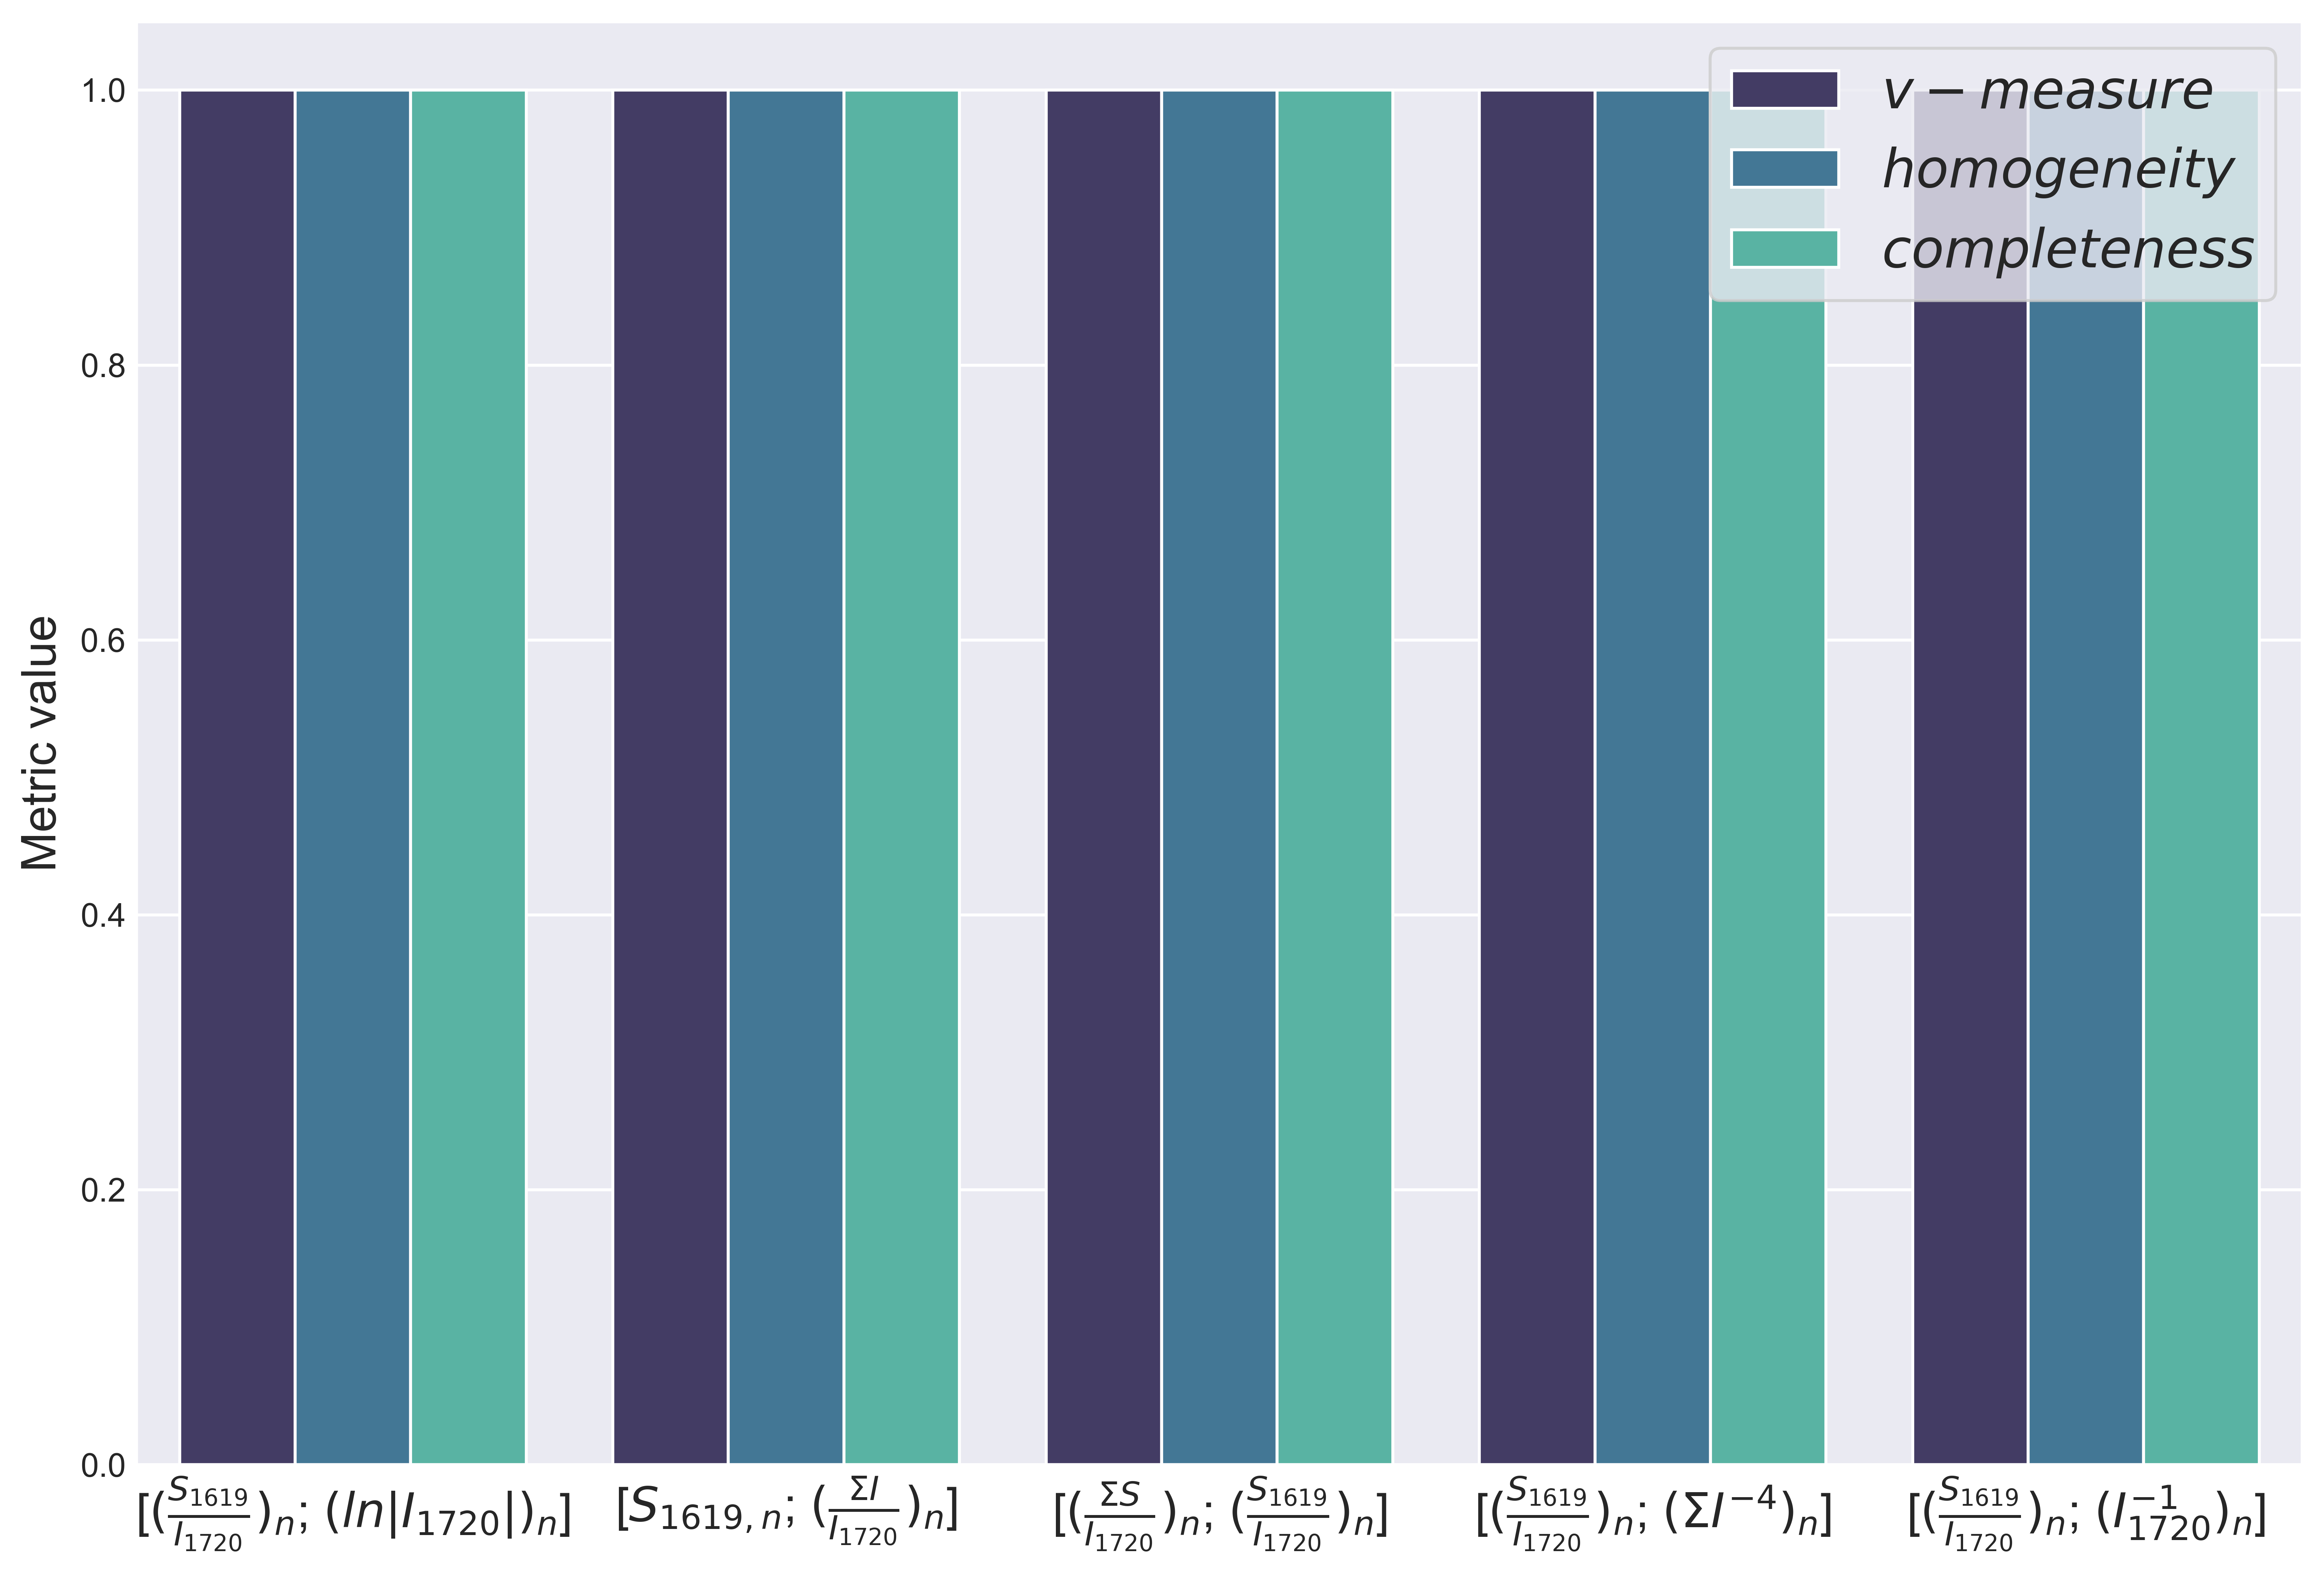

In [15]:
sns.set_theme()

fig = plt.figure(figsize=(11, 7.5), dpi=600, linewidth=1.0)

ax = fig.gca()

ax.grid(True)
ax.tick_params(direction='in')

bar = sns.barplot(data=qm_df_vis_top,
                  x='Feature_Pair',
                  y='Value',
                  hue='Metric',
                  palette='mako',
                  ax=ax)

ax.set_ylabel('Metric value',
              fontstyle='normal',
              fontsize=16,
              rotation=90,
              labelpad=5)

ax.set_xlabel('')

bar.set_xticklabels(bar.get_xticklabels(), rotation=0, fontsize=16)

plt.tight_layout()

ax.legend(loc='upper right', fontsize=18)

plt.savefig(path_to_save + '/qm_barplot.png', dpi=600)
plt.show()

### Scatterplot in the coodirnares of *top-1, 2, 3* features pair

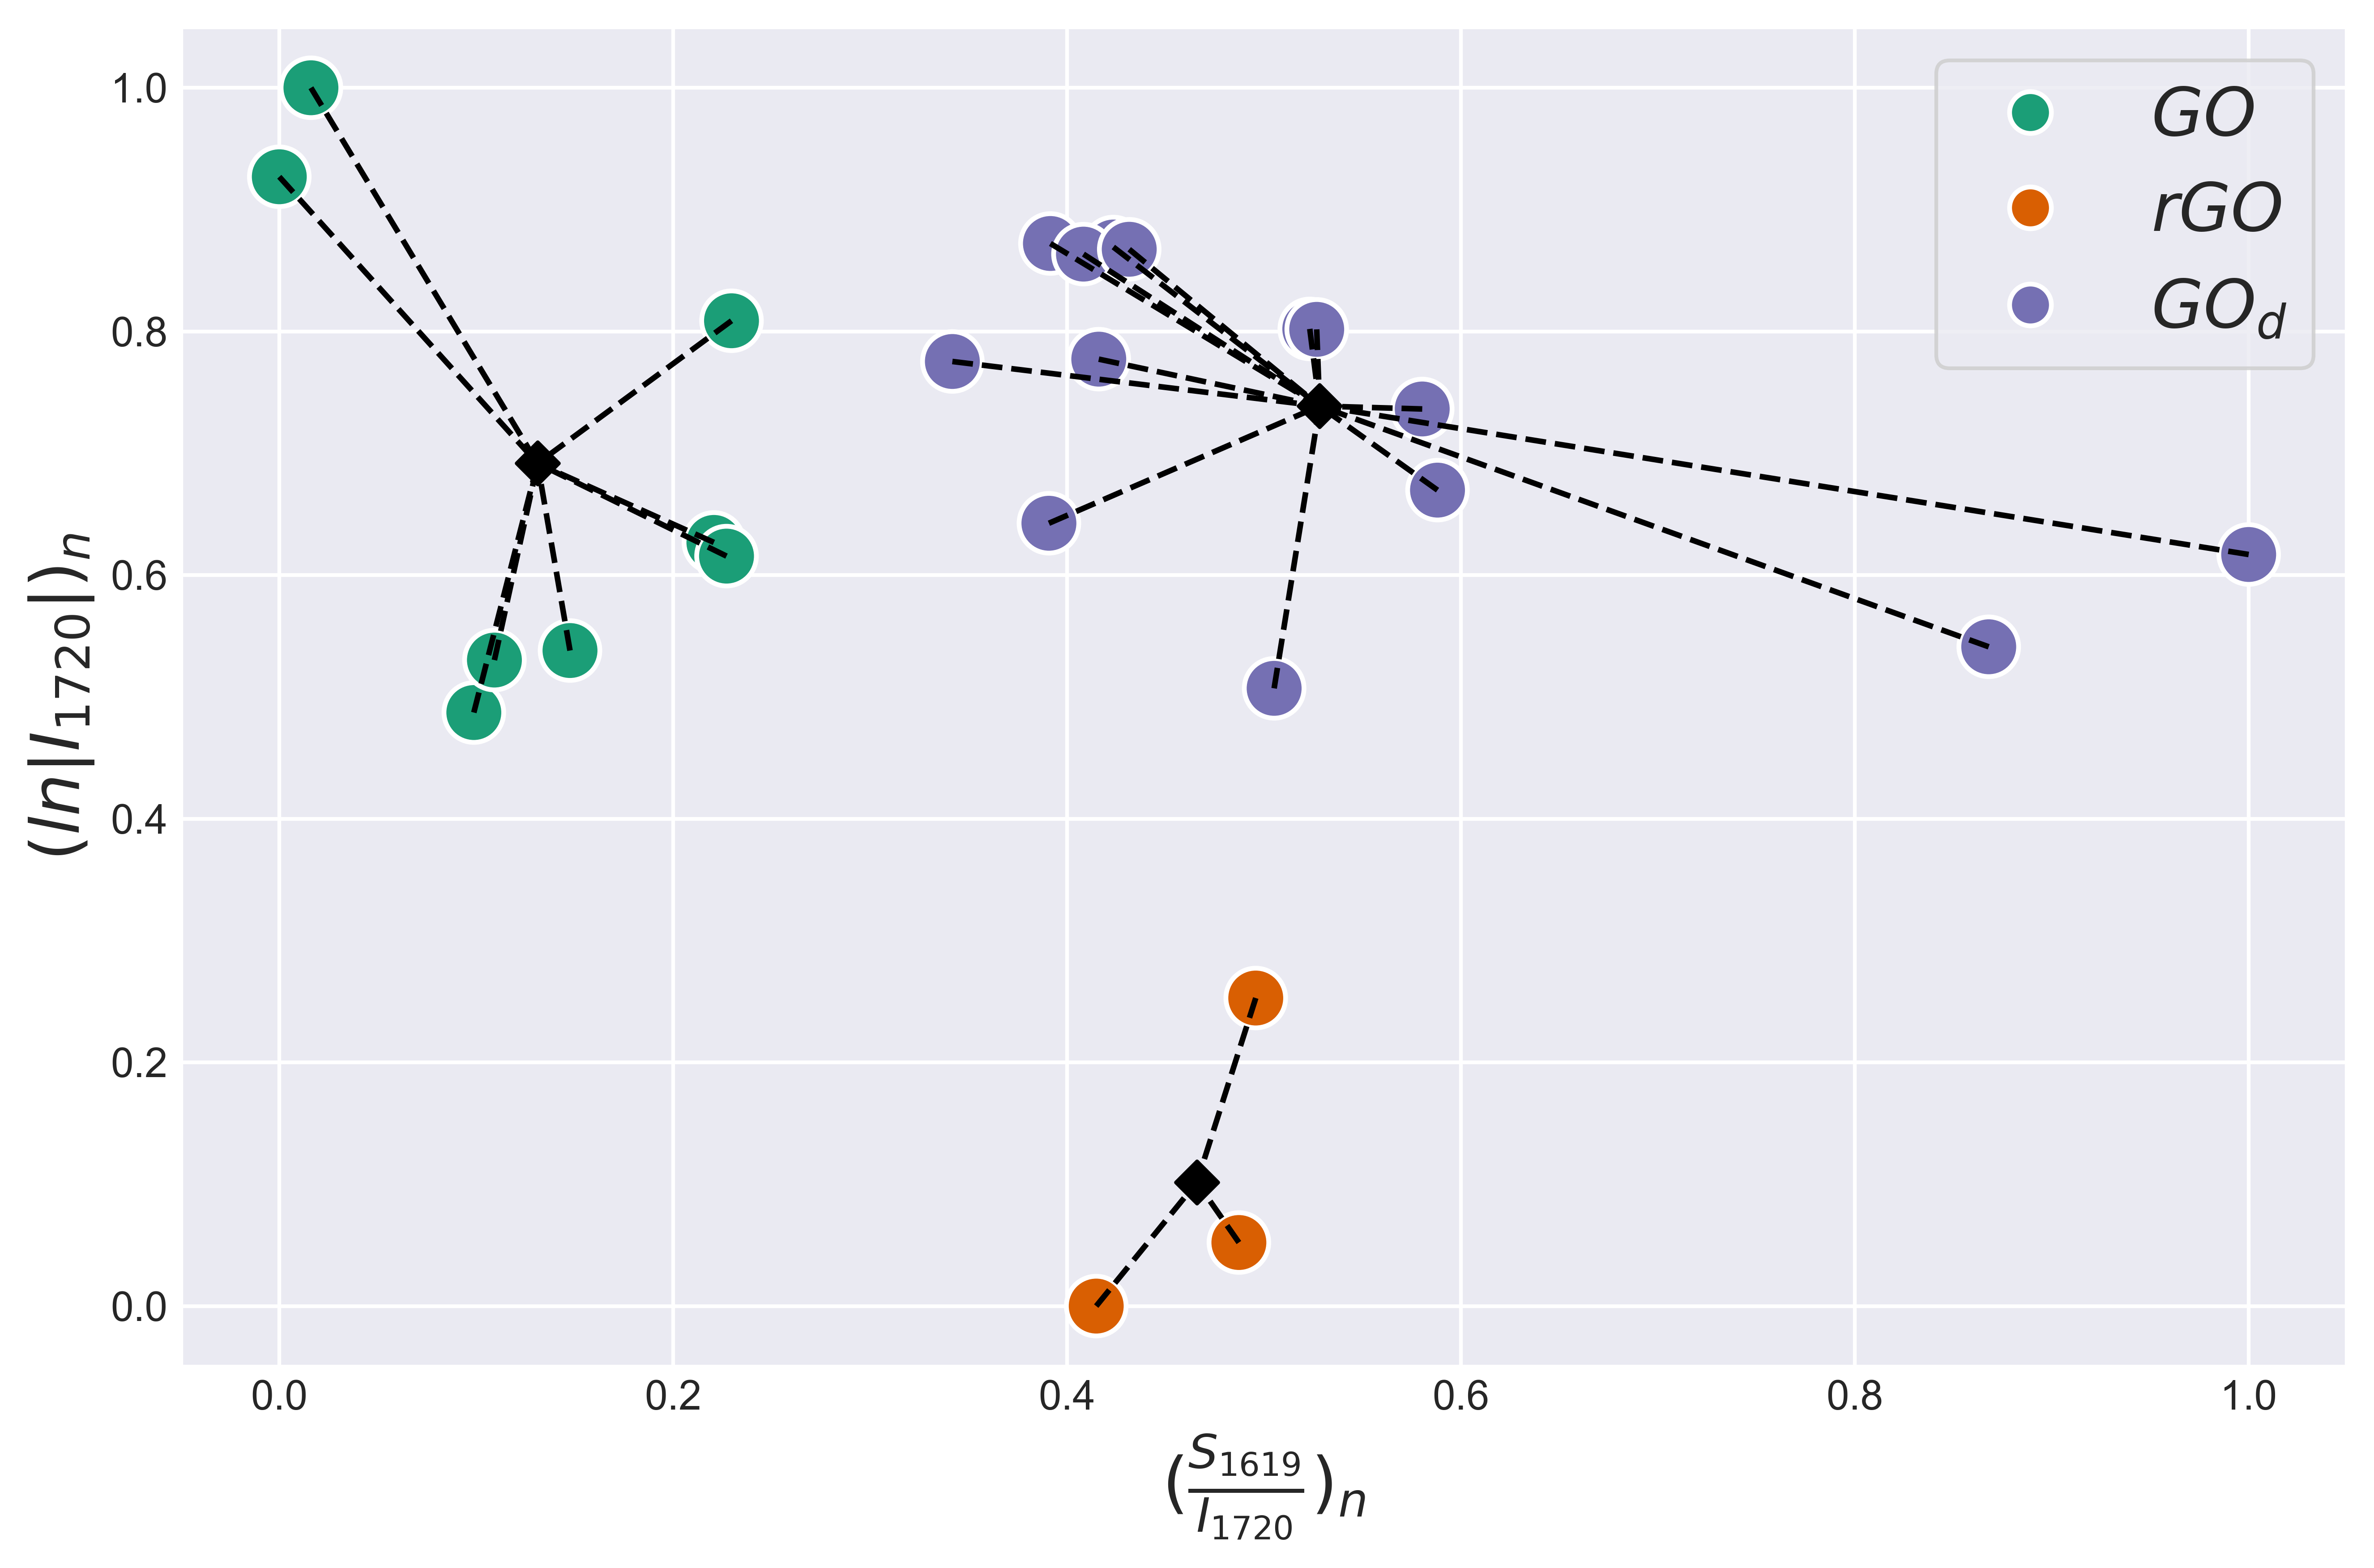

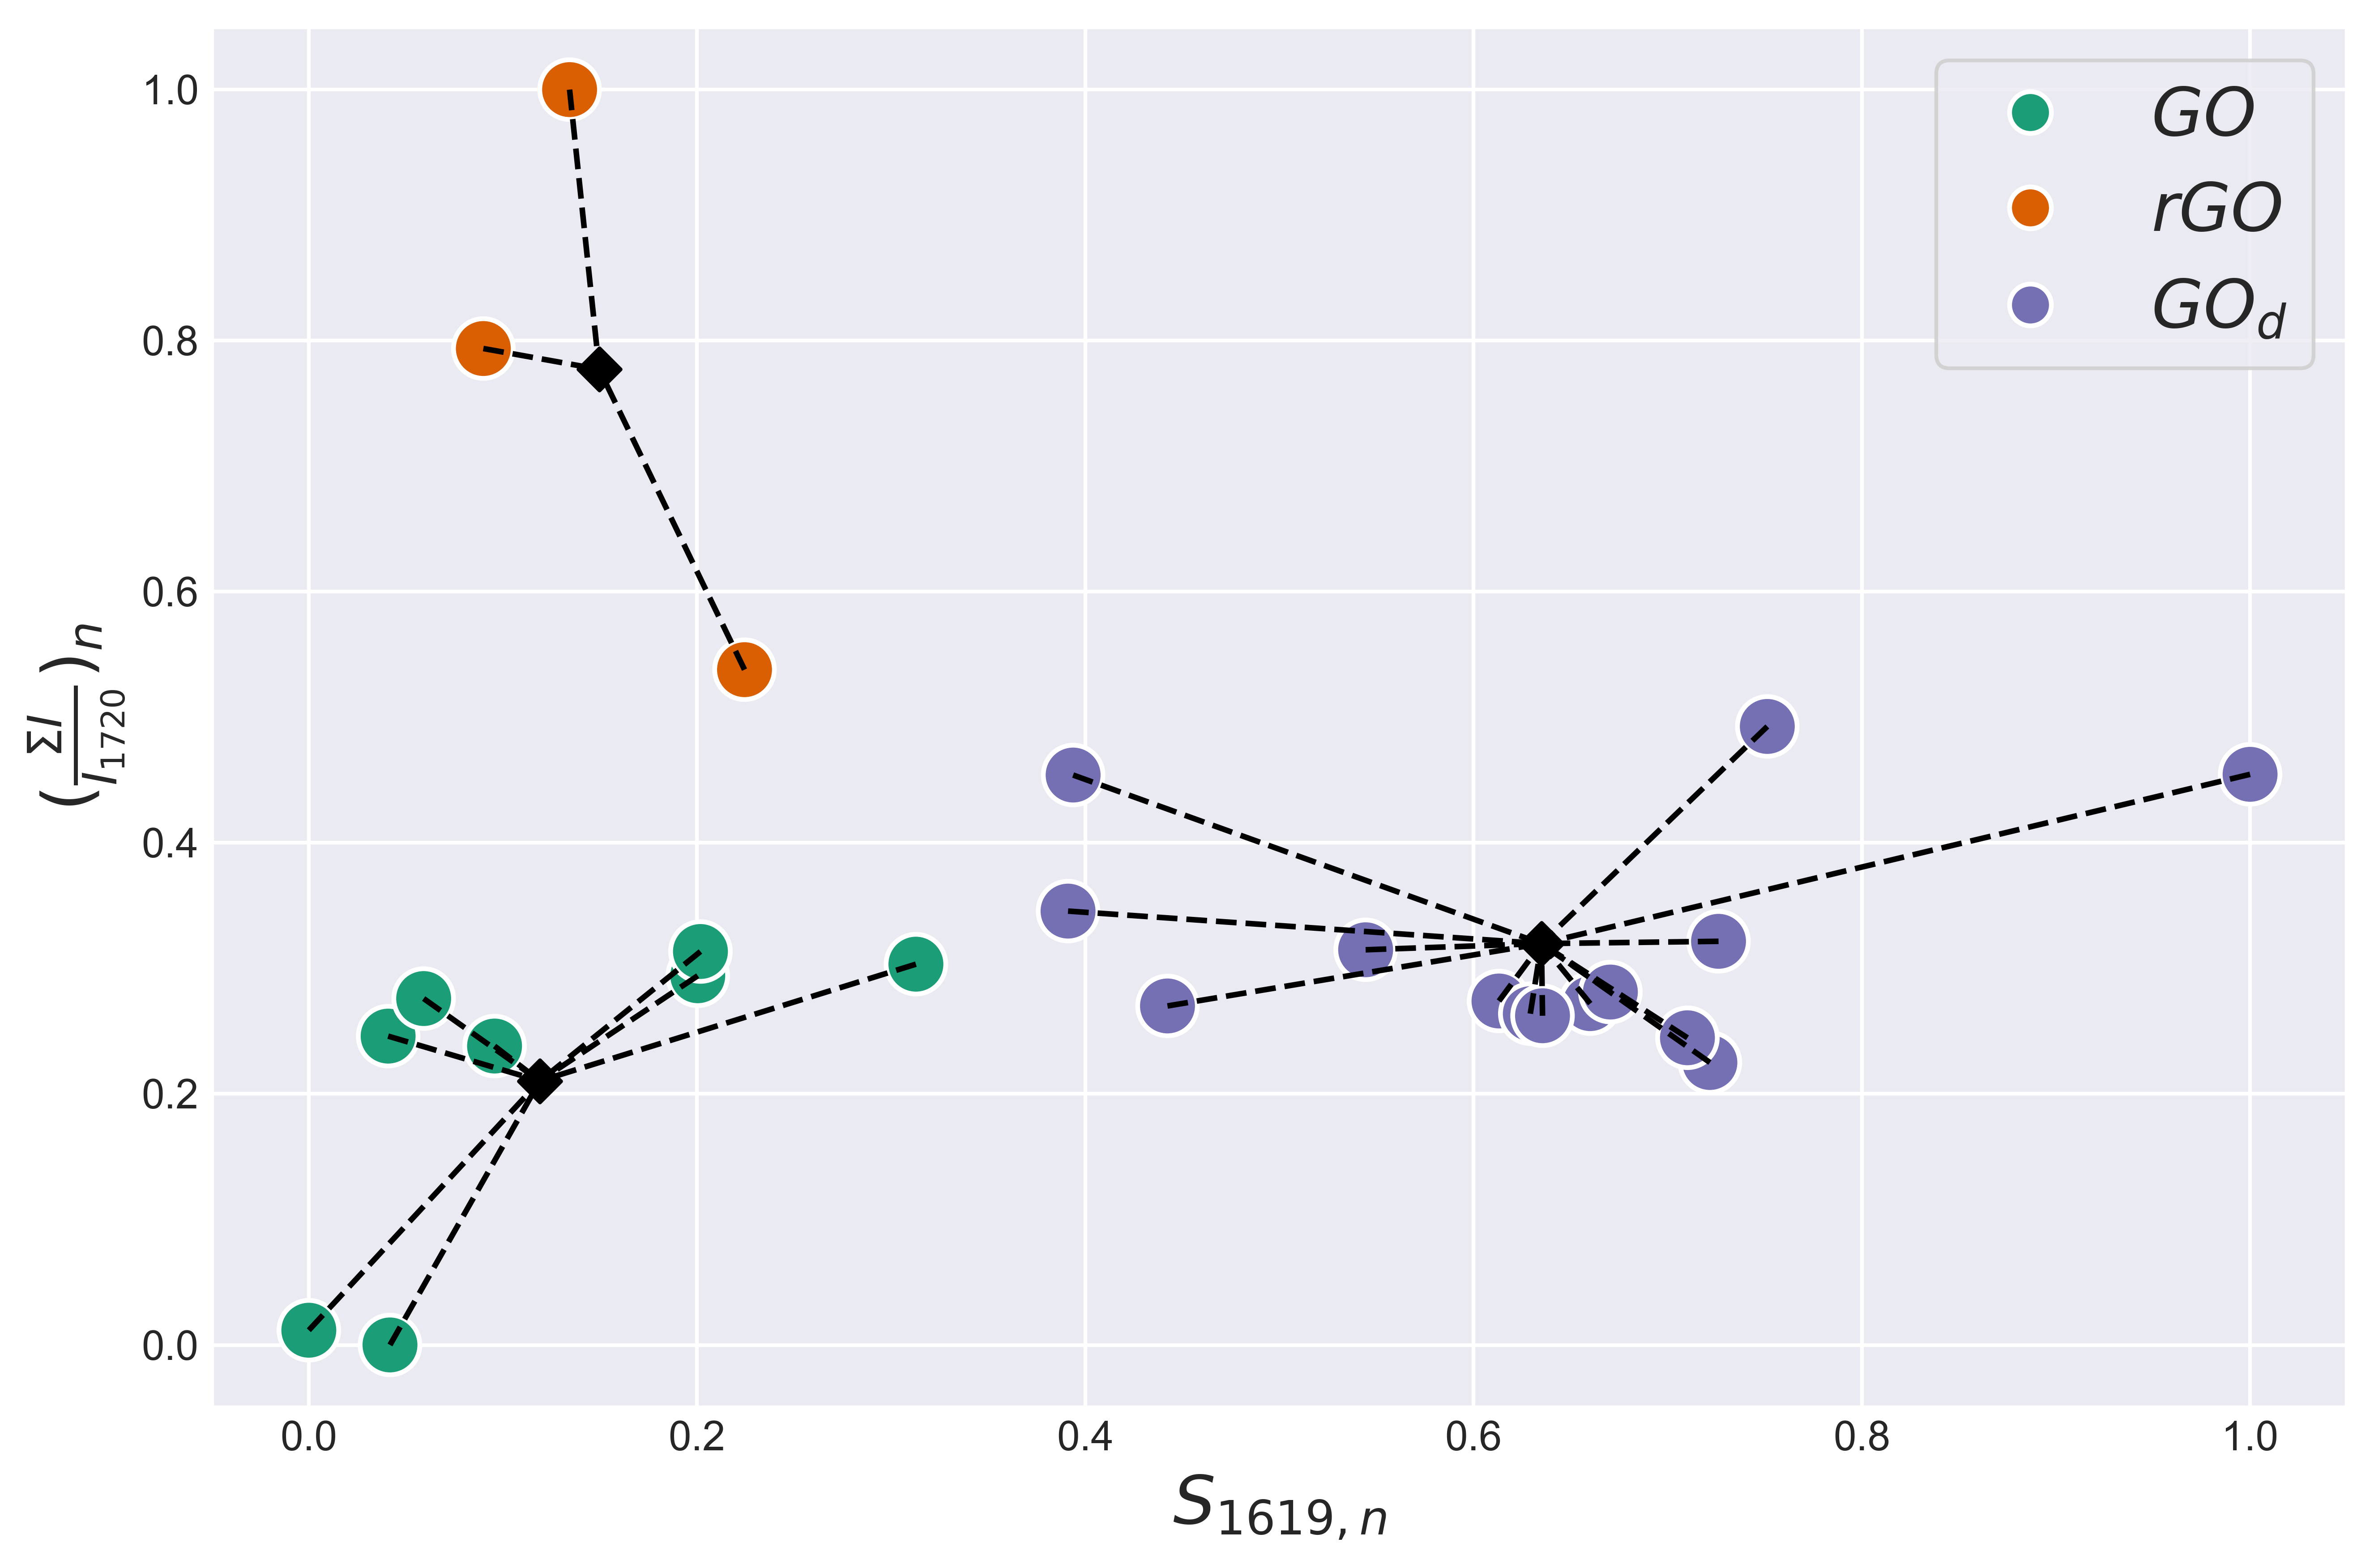

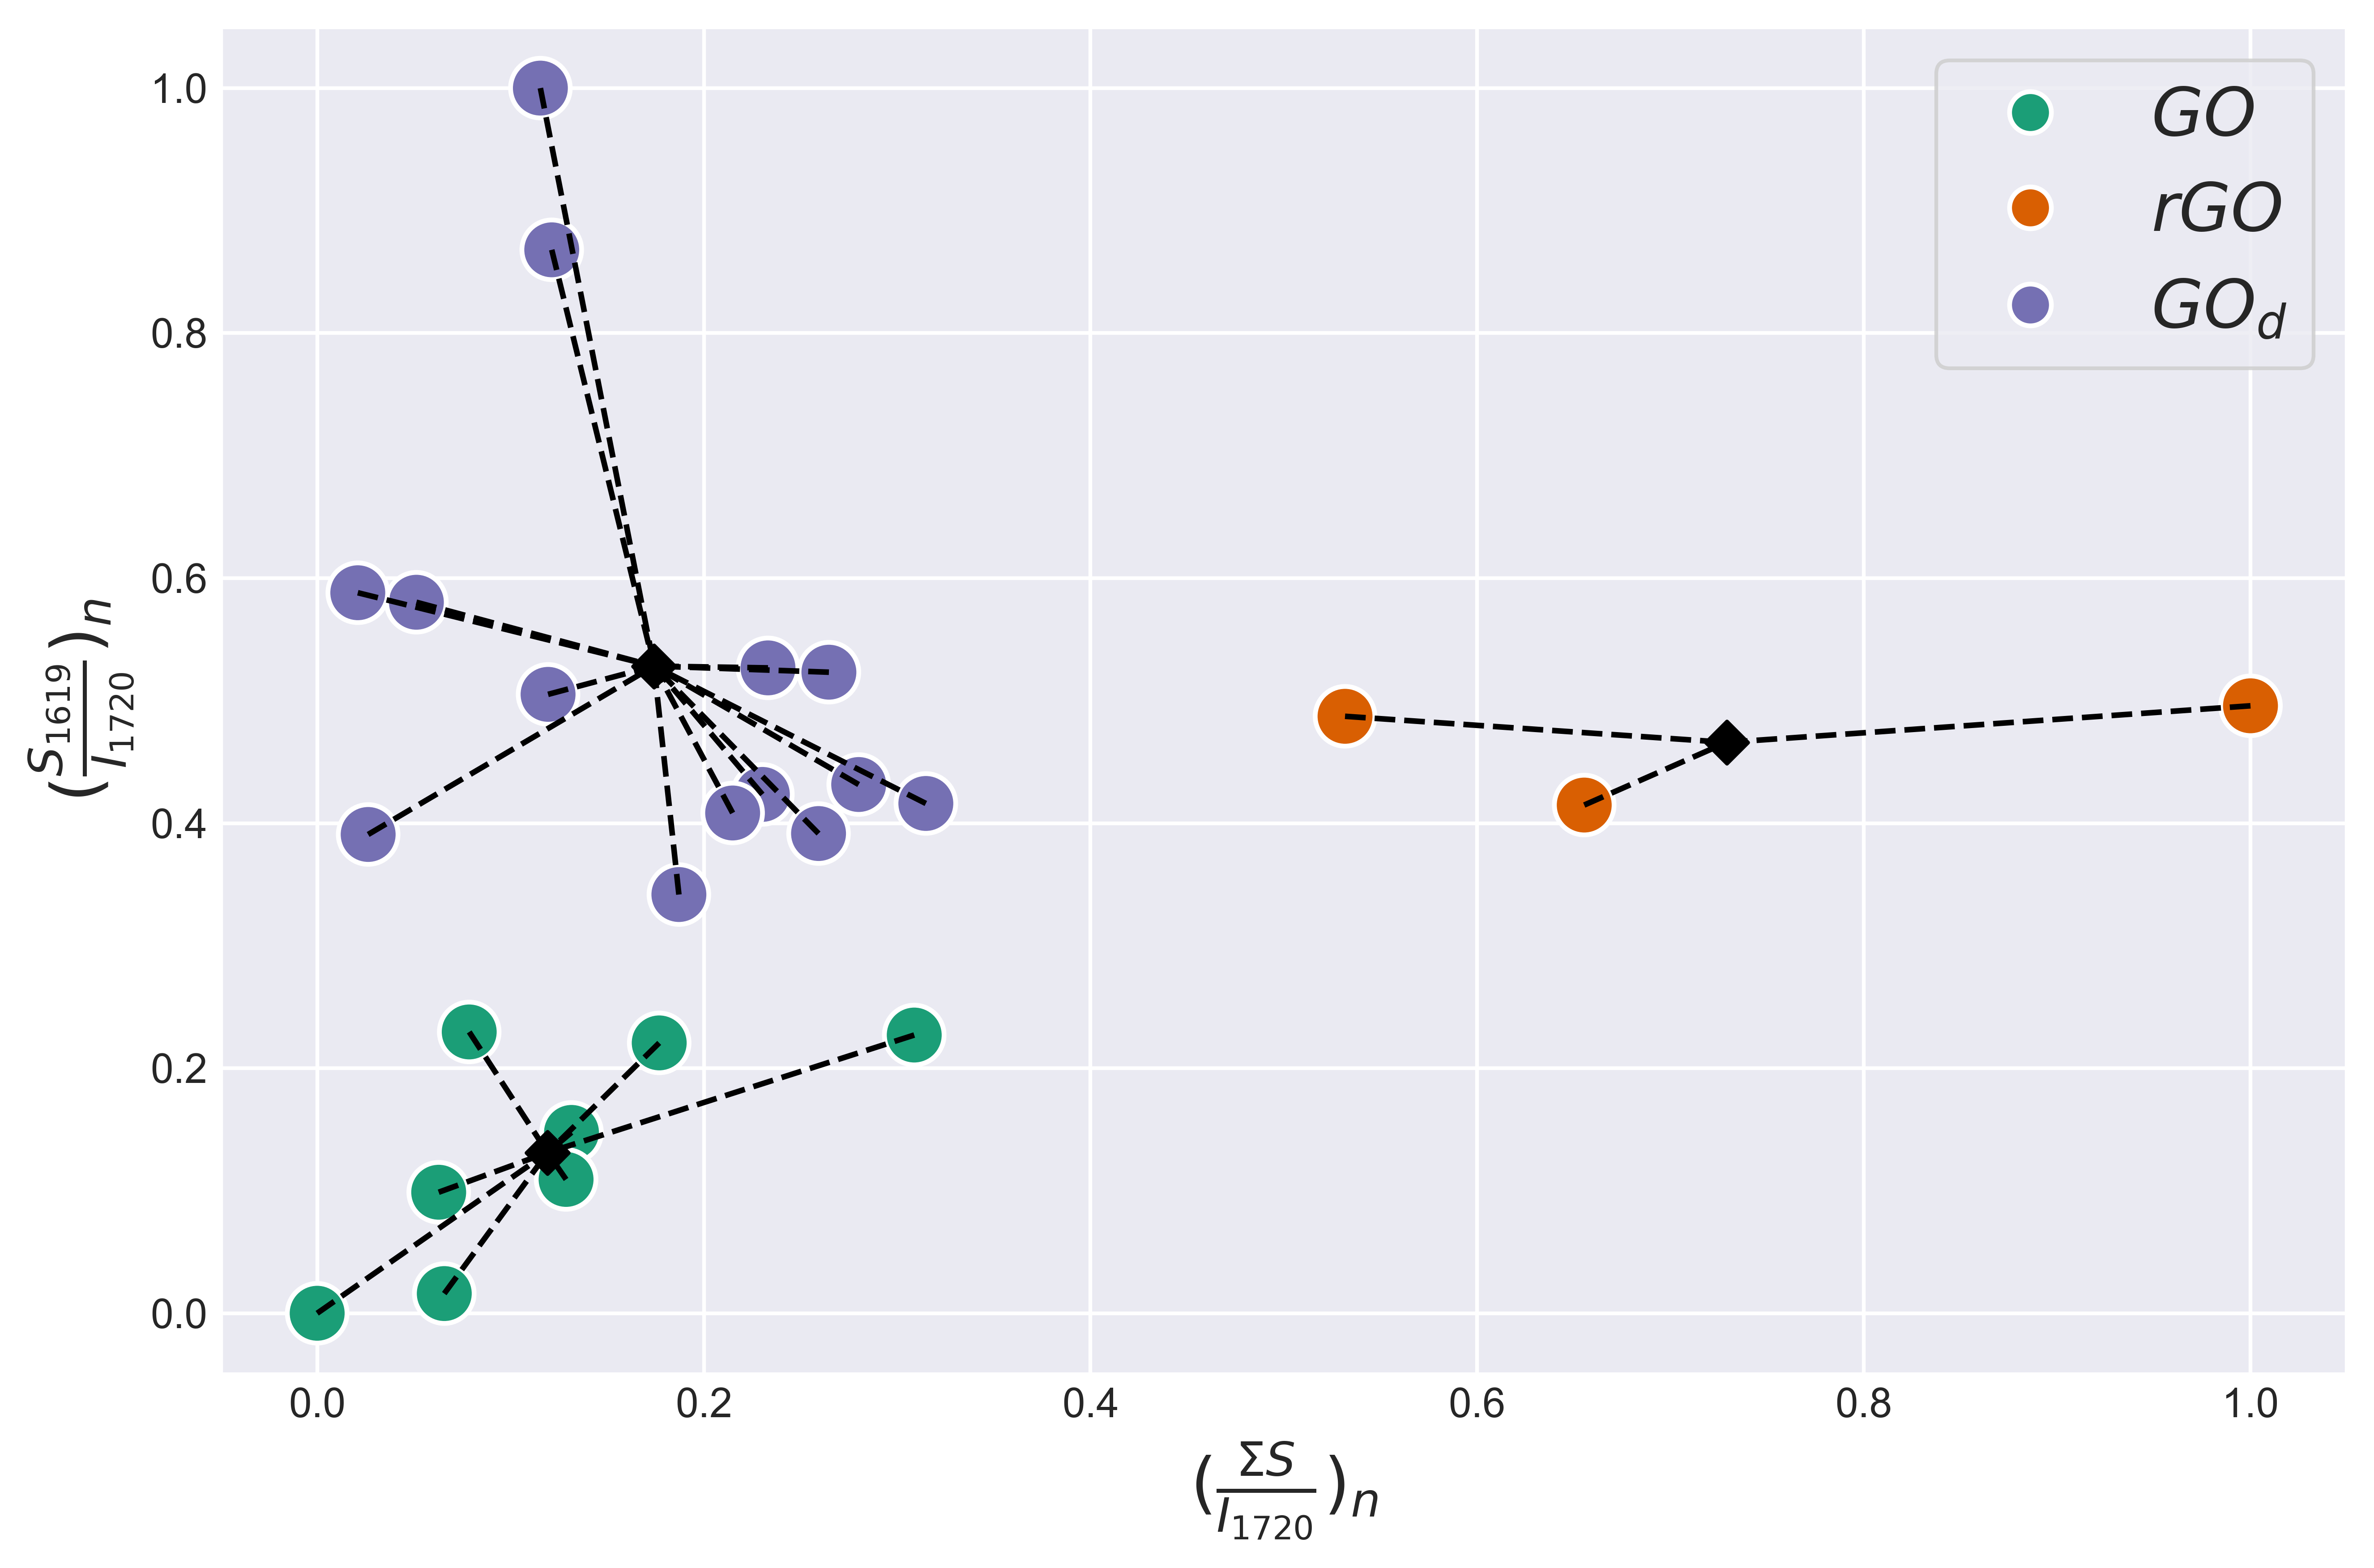

In [41]:
top_n = 3 

for i in range(top_n):
    feature_1, feature_2 = qm_df_vis_top['Feature_1'].tolist()[i], qm_df_vis_top['Feature_2'].tolist()[i]
    
    top_features_pair_df = data.loc[:, [feature_1, feature_2]]
        
    target = samples_description['Class']
    hue = samples_description['Type']
    
    analyzer = ClusterAnalysis2D(target=target, hue=hue)
    
    opt_n_cluster = analyzer.optimize_n_clusters(train_data=top_features_pair_df,
                                                 metric='v_measure')
    
    analyzer.fit_transform_kmeans(train_data=top_features_pair_df,
                                  n_clusters=opt_n_cluster)

    if i == 0:
        full_path_to_save = path_to_save + f'/scatterplot_top{i}.png'
    else:
        full_path_to_save = None
    
    analyzer.get_clustering_visualization(figsize=(9, 6.0),
                                          markersize=256,
                                          fontsize=18,
                                          print_point_labels=False,
                                          path_to_save=full_path_to_save,
                                          dpi=600)

### Detailed analysis — scatterplot in the coodirnares of *top-1* features pair grouped by sample type

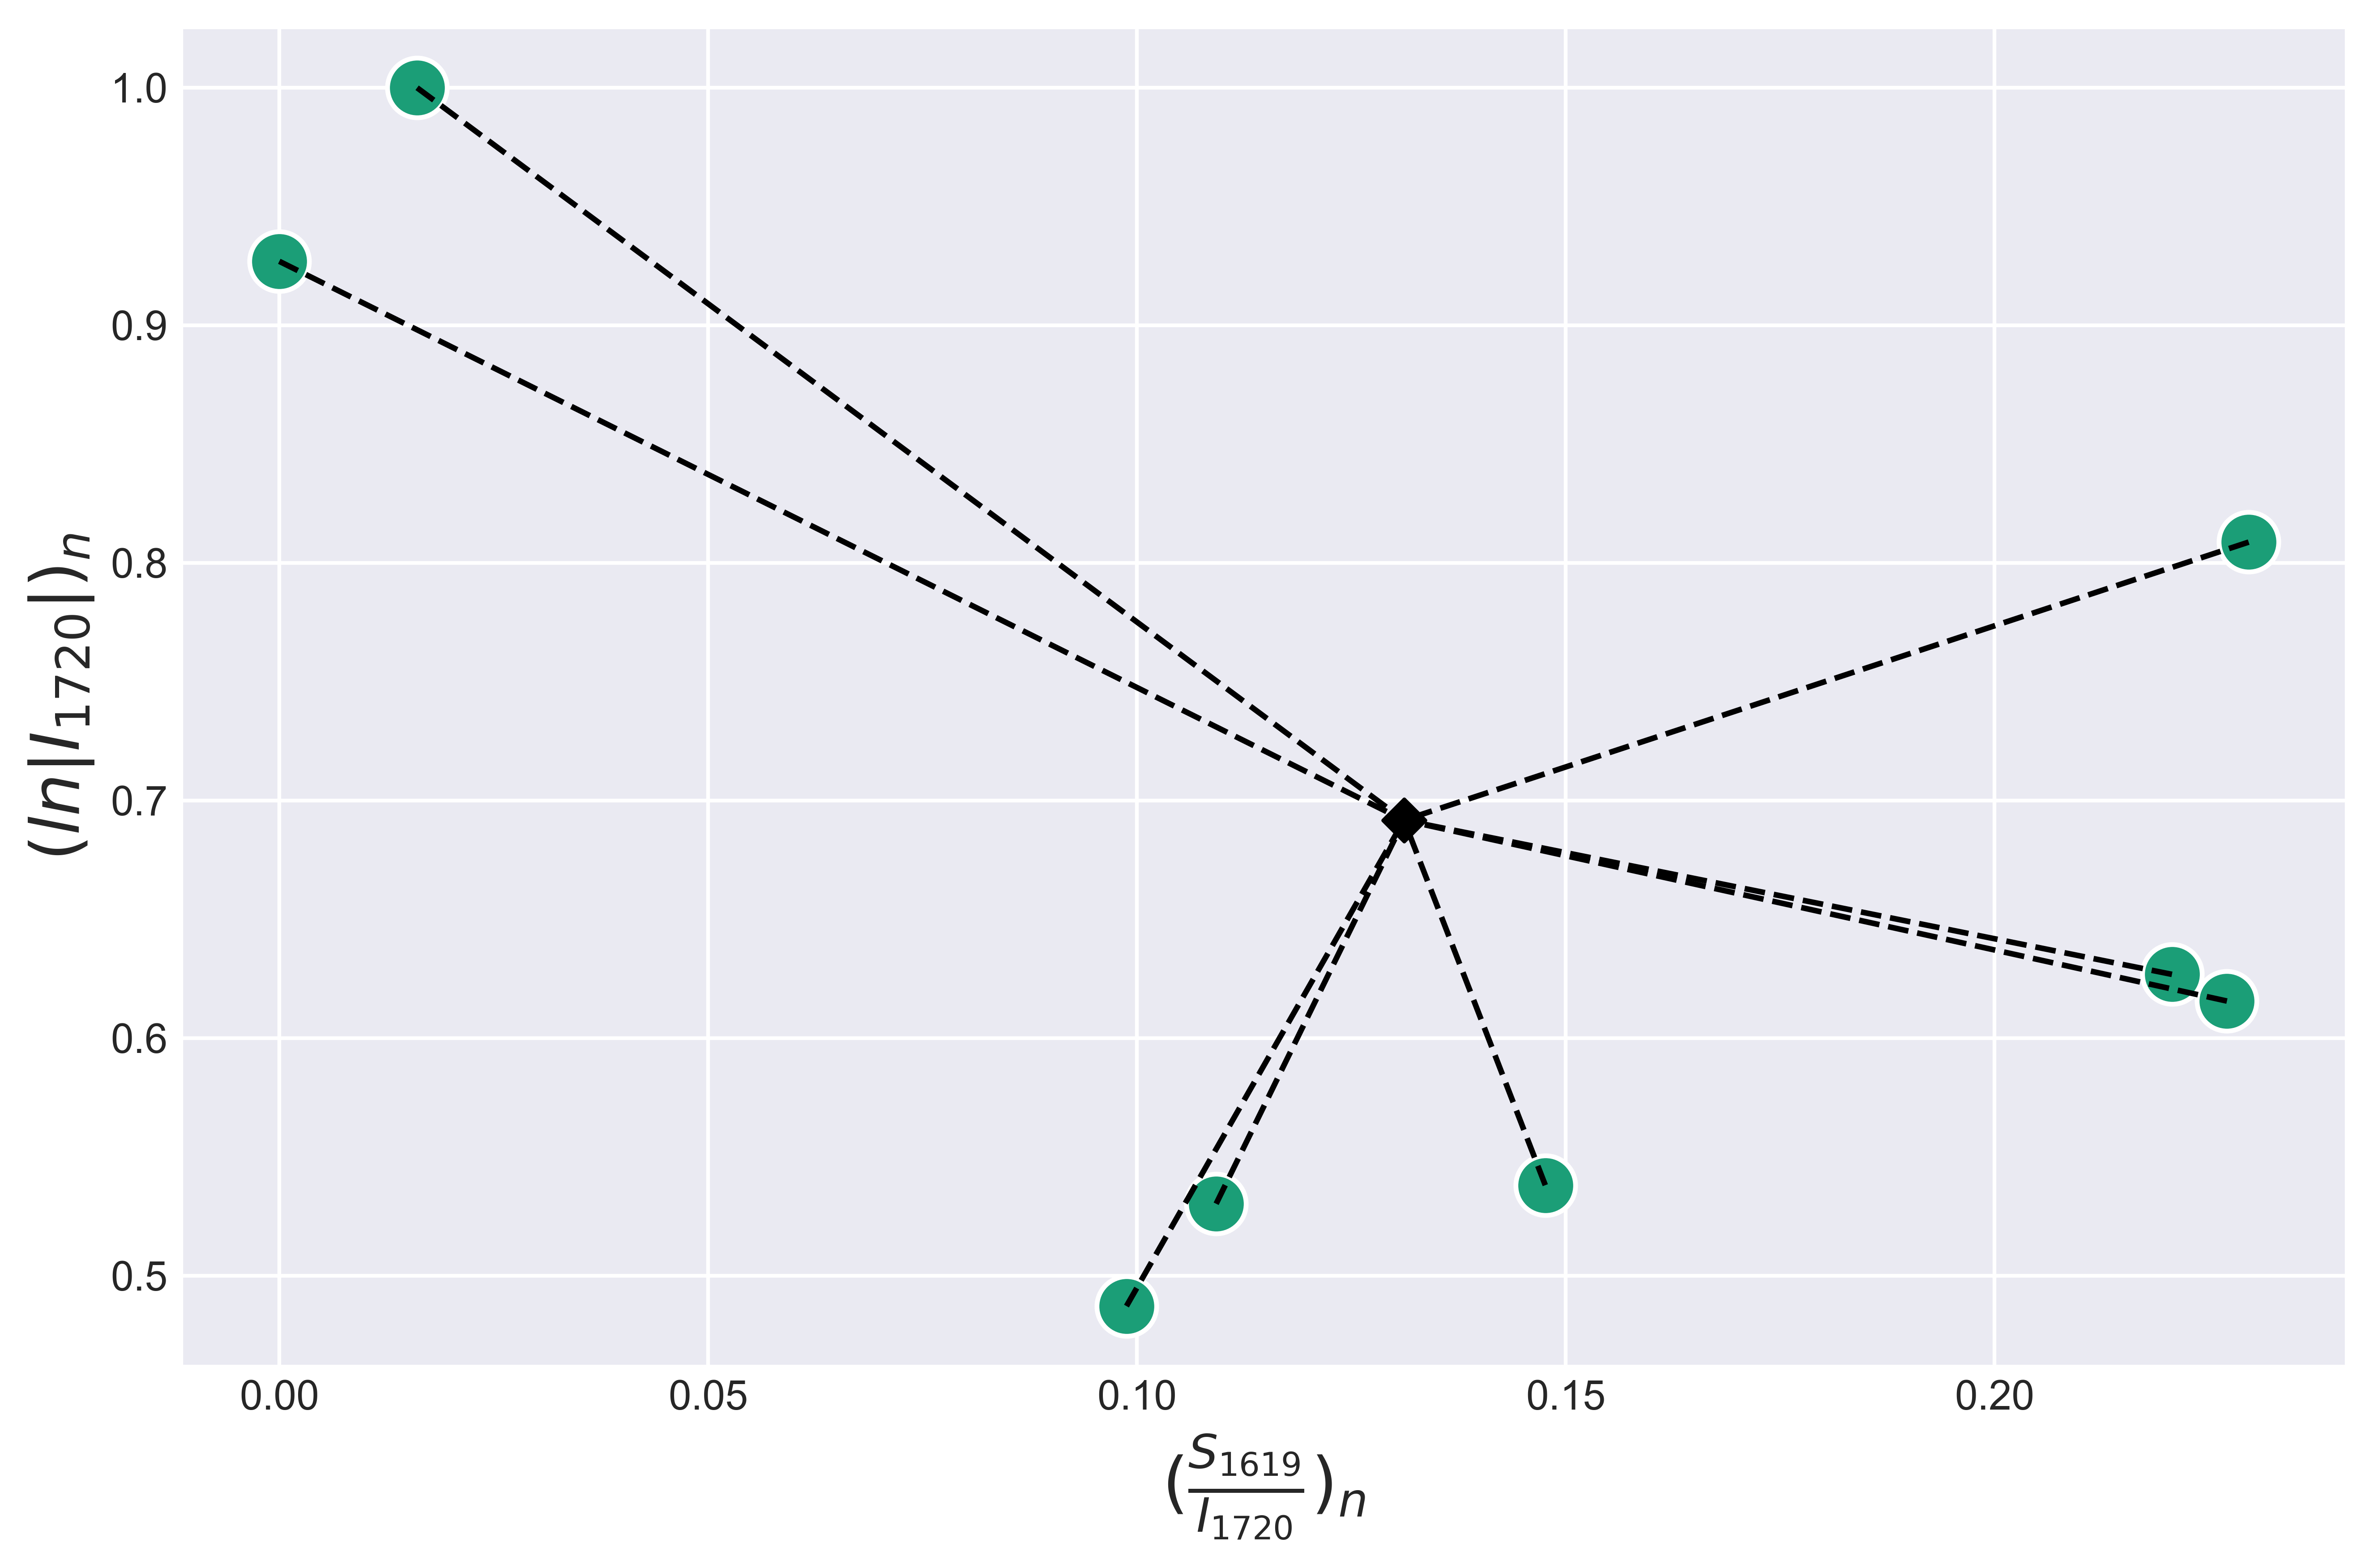

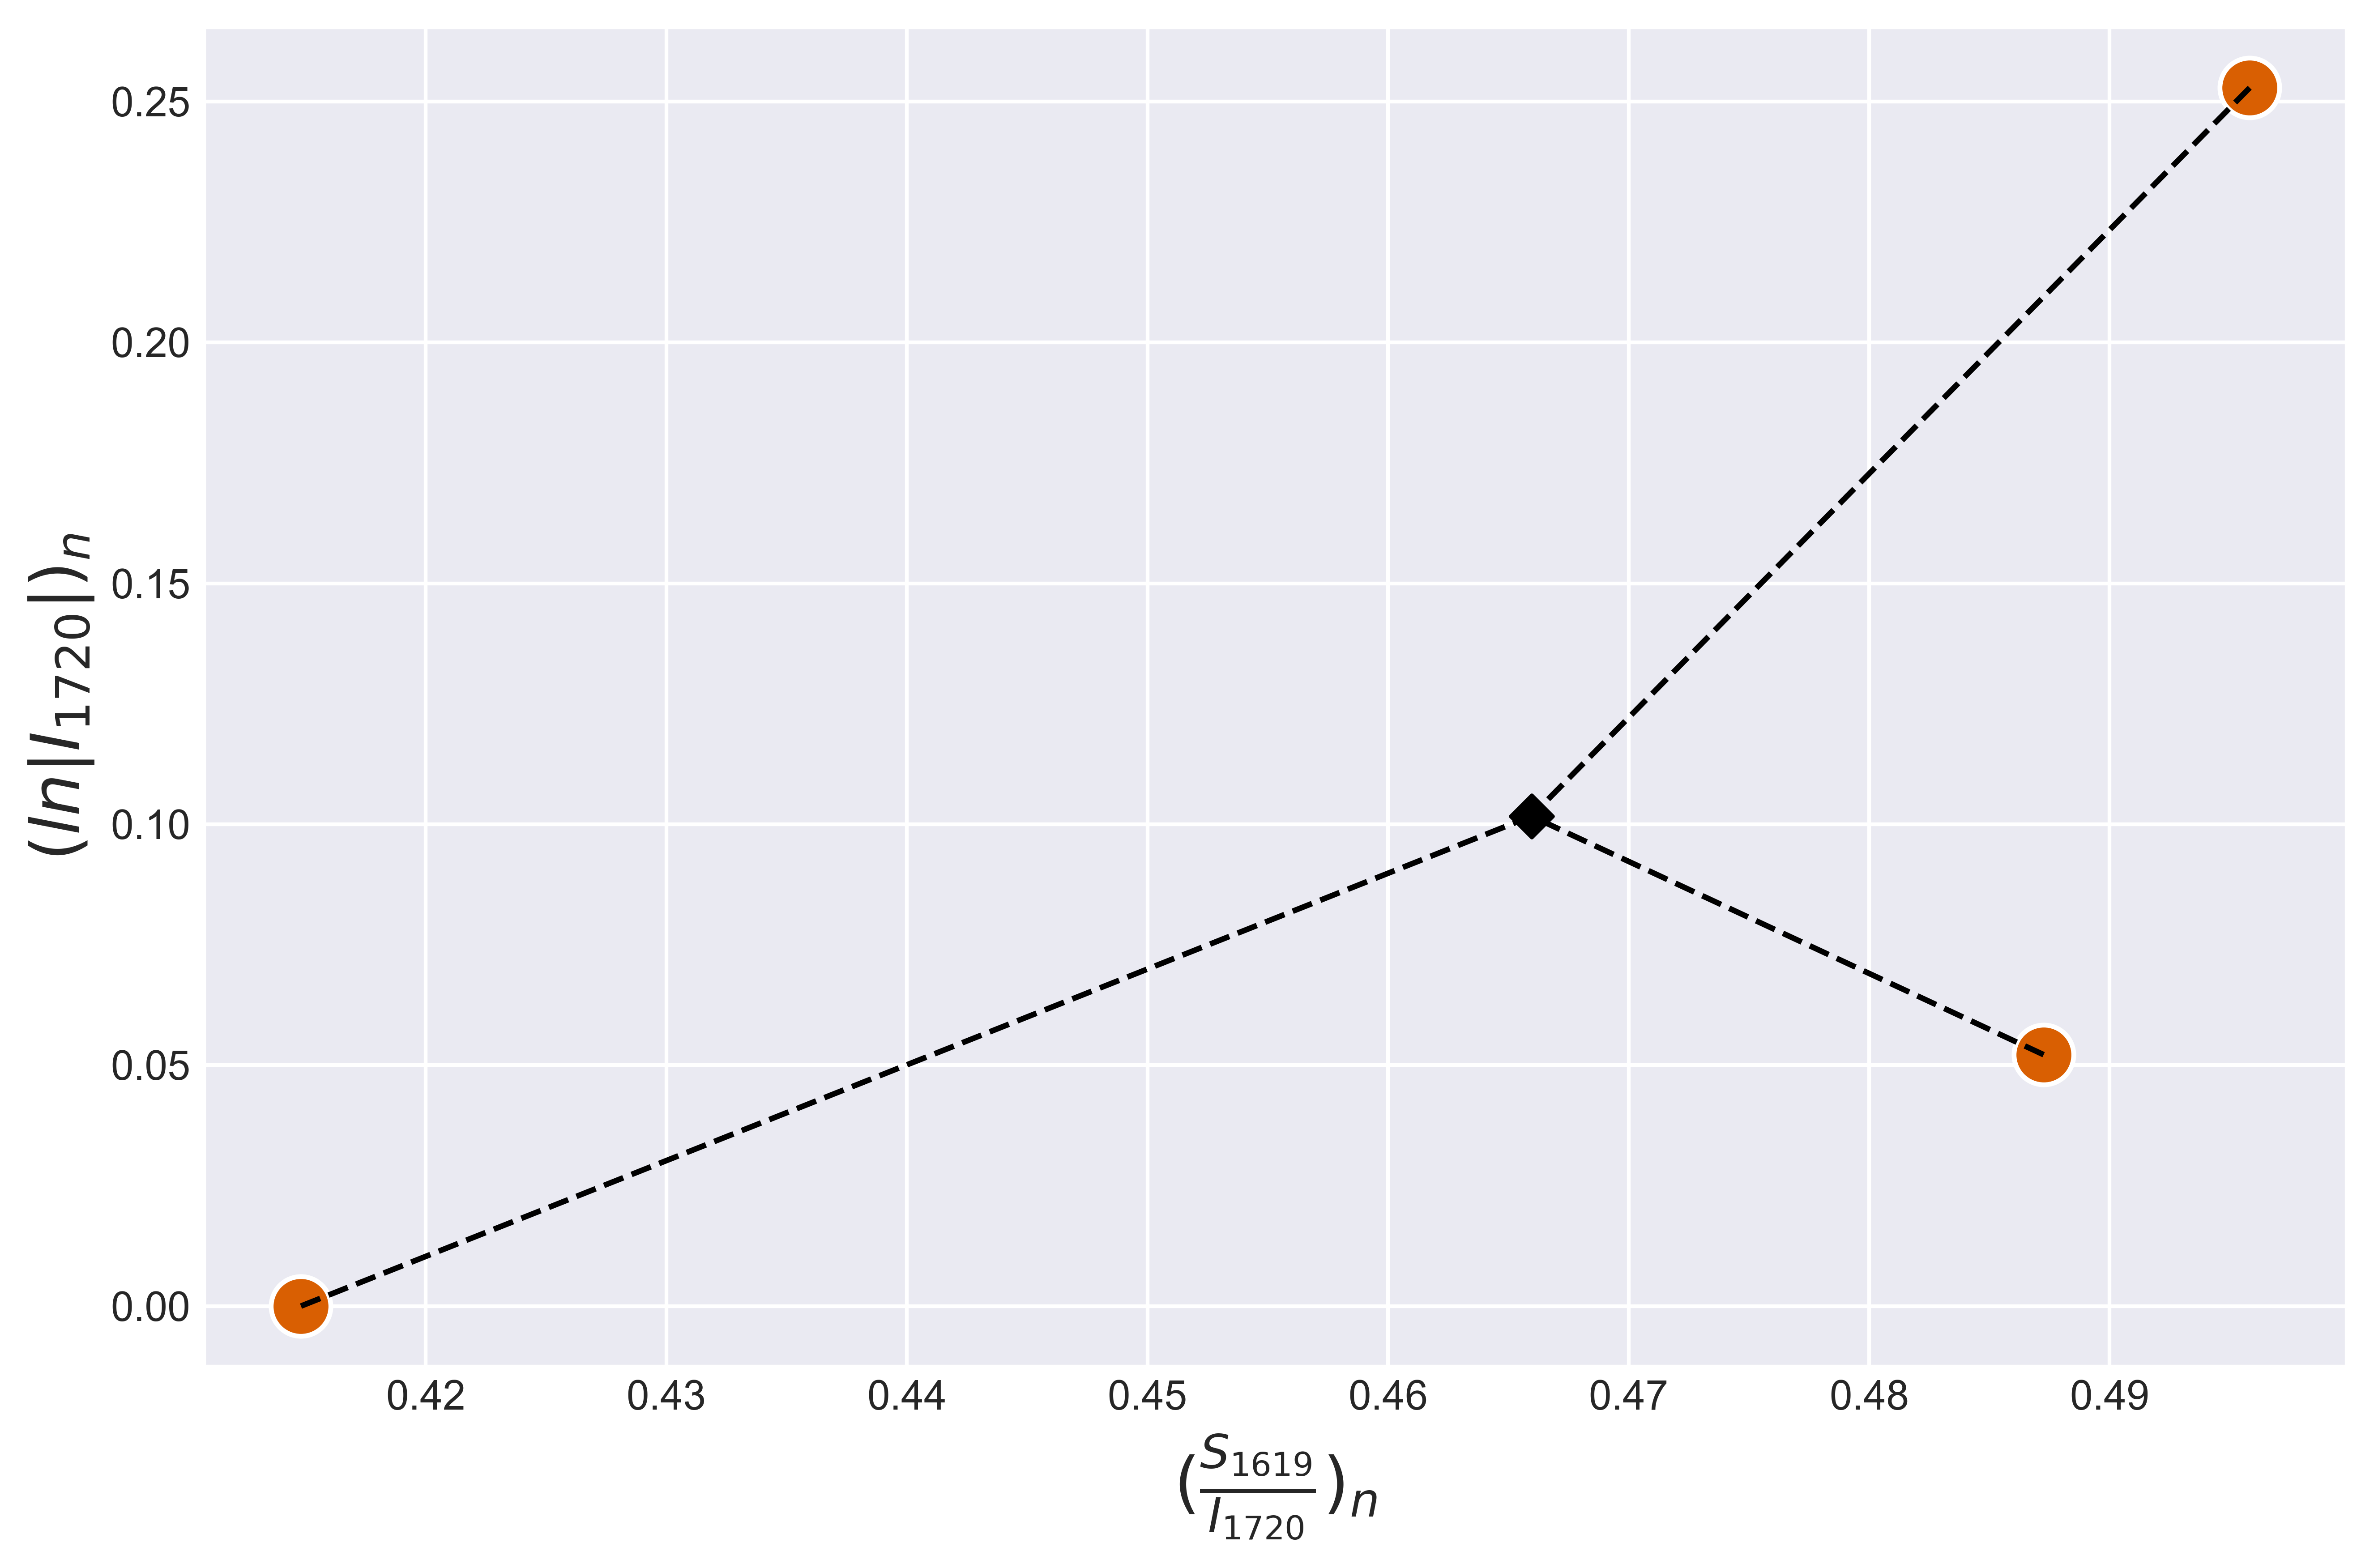

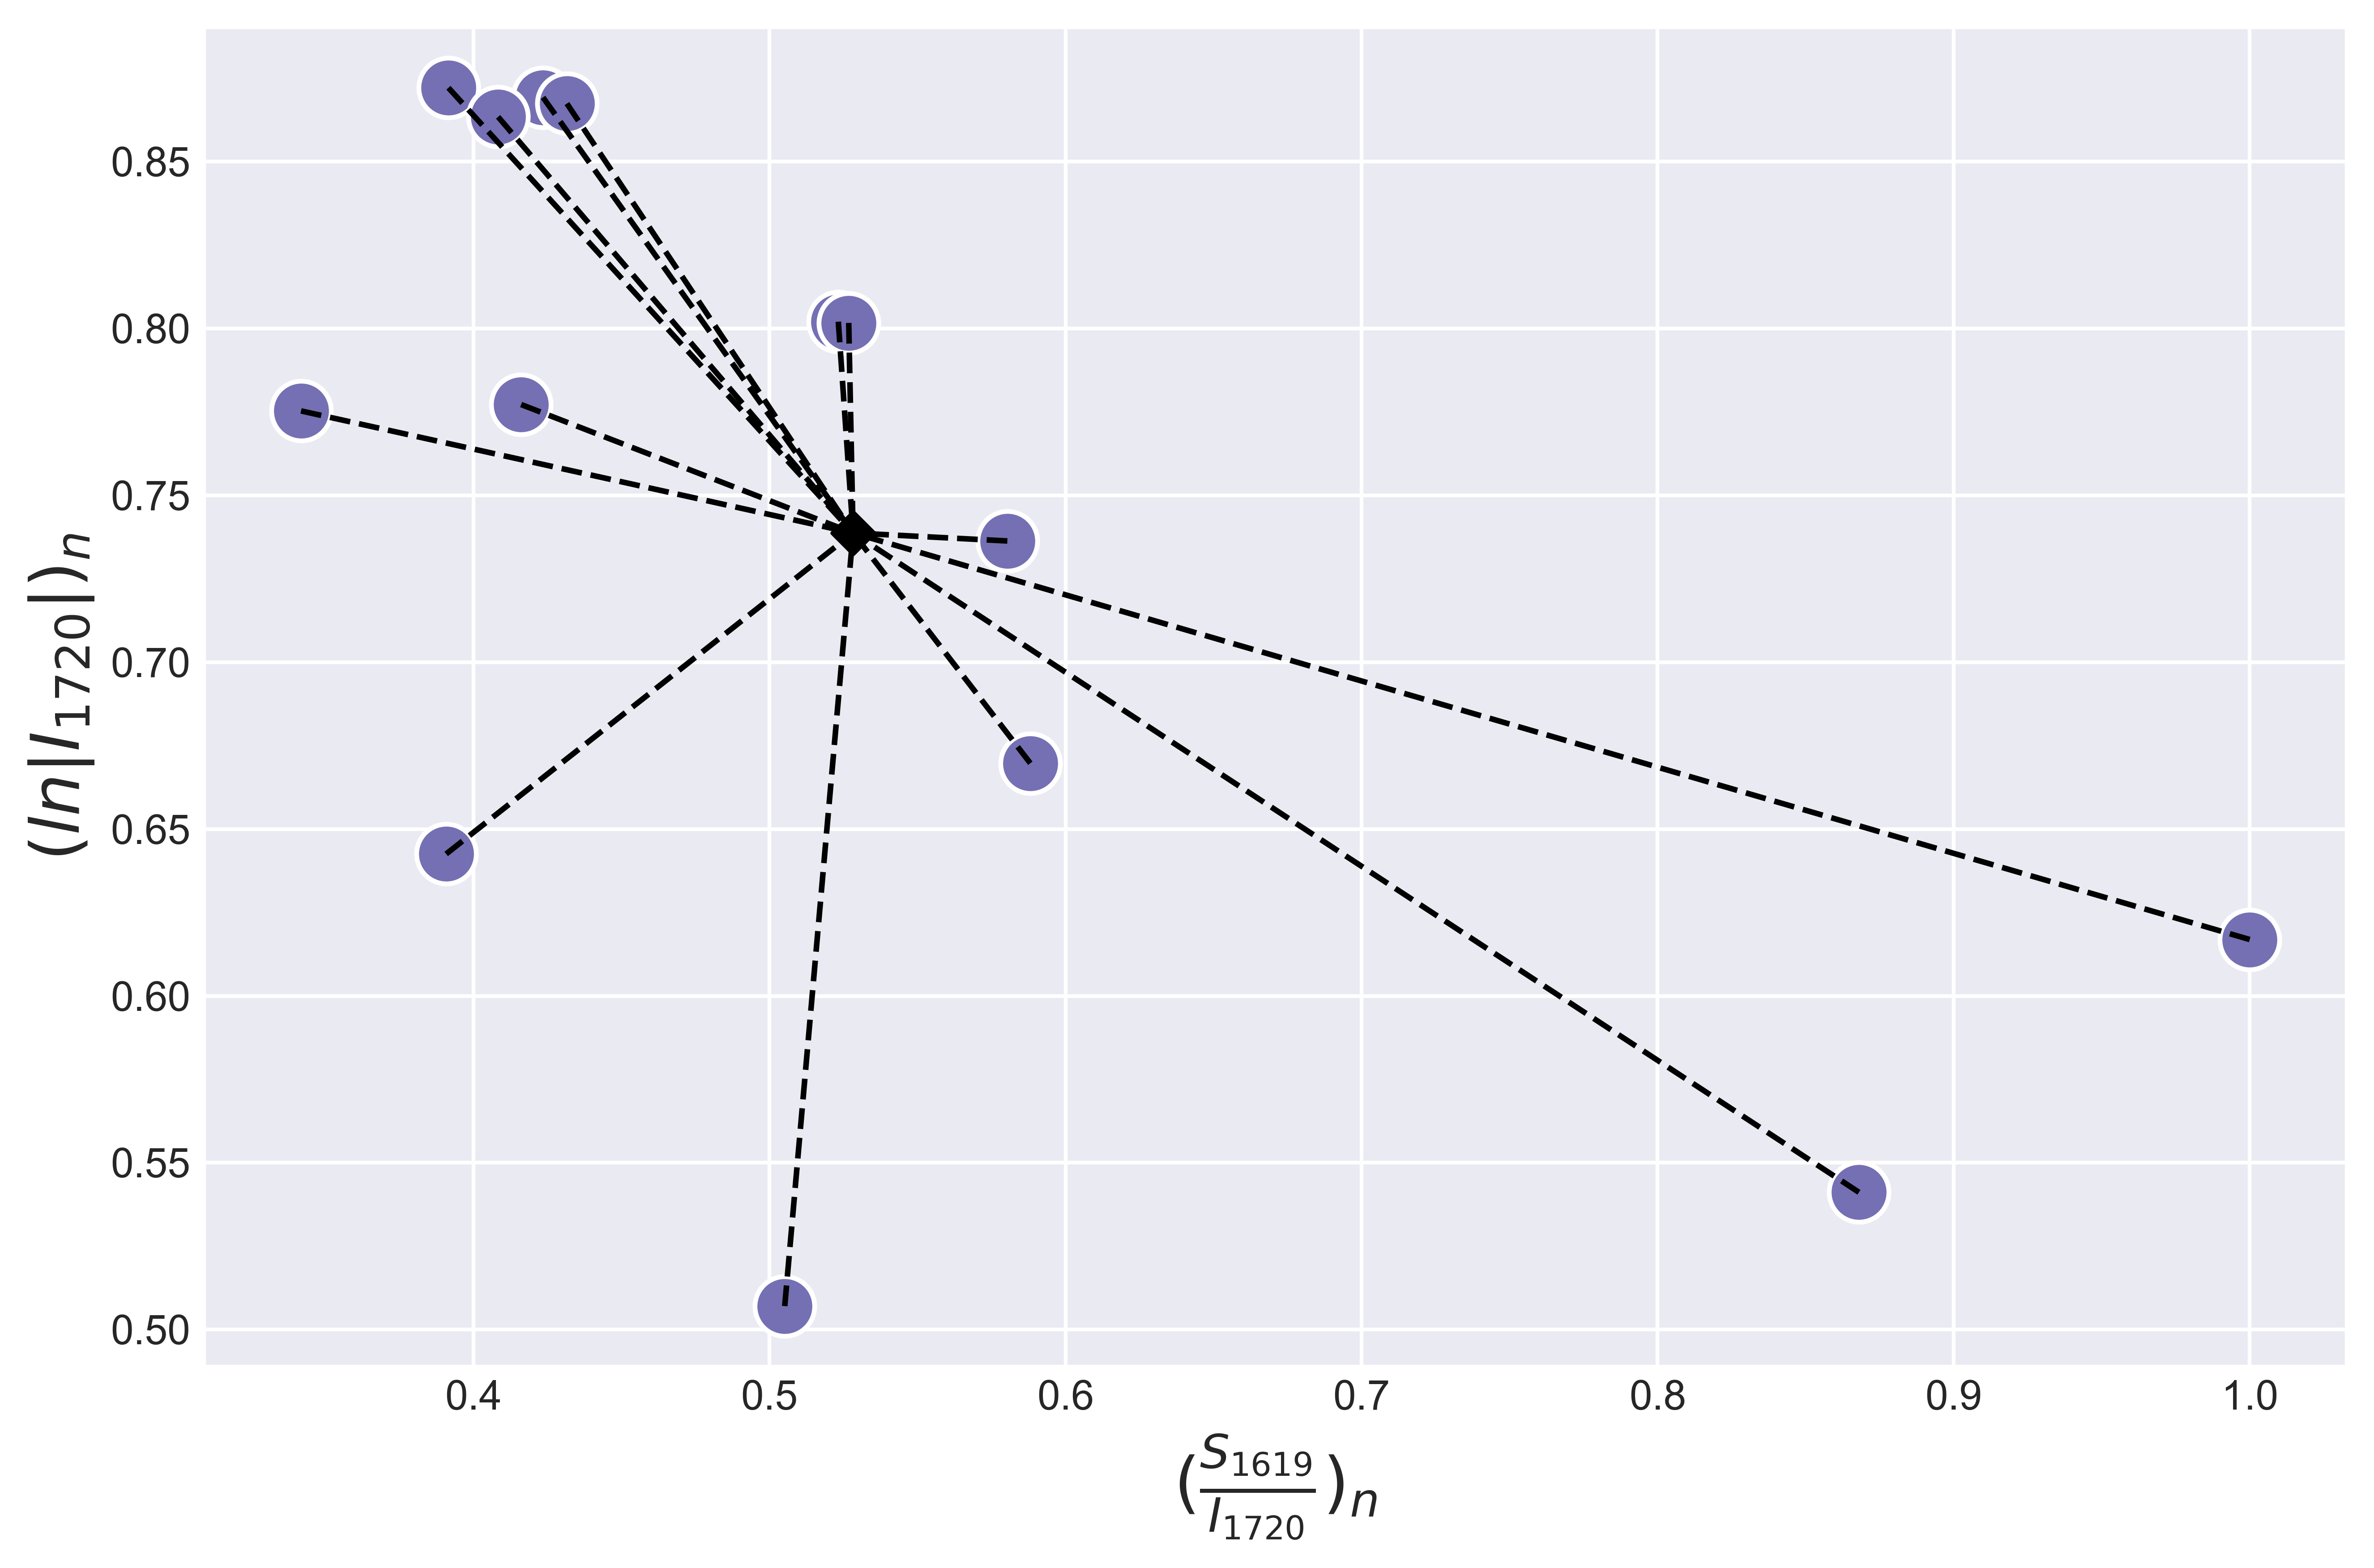

In [43]:
sample_types = samples_description['Type'].unique().tolist()
colors_lst = ['#1b9e77', '#d95f02', '#7570b3']

n = 0

for i, sample_type in enumerate(sample_types):
    feature_1, feature_2 = qm_df_vis_top['Feature_1'].tolist()[n], qm_df_vis_top['Feature_2'].tolist()[n]

    sample_type_indexes = samples_description.loc[samples_description['Type'] == sample_type].index
    
    top_features_pair_df = data.loc[:, [feature_1, feature_2]].loc[sample_type_indexes]
        
    target = samples_description['Class'].loc[sample_type_indexes]
    hue = samples_description['Type'].loc[sample_type_indexes]
    
    analyzer = ClusterAnalysis2D(target=target, hue=hue)
    
    opt_n_cluster = analyzer.optimize_n_clusters(train_data=top_features_pair_df,
                                                 metric='v_measure')
    
    analyzer.fit_transform_kmeans(train_data=top_features_pair_df,
                                  n_clusters=opt_n_cluster)
    
    analyzer.get_clustering_visualization(
        figsize=(9.0, 6.0),
        markersize=256,
        fontsize=18,
        palette=None,
        color=colors_lst[i],
        print_point_labels=False,
        path_to_save=path_to_save + f'/scatterplot_top{i}_{sample_type}.png',
        dpi=600
    )

*More detailed anlysis with printing sample if for each point (=sample)*

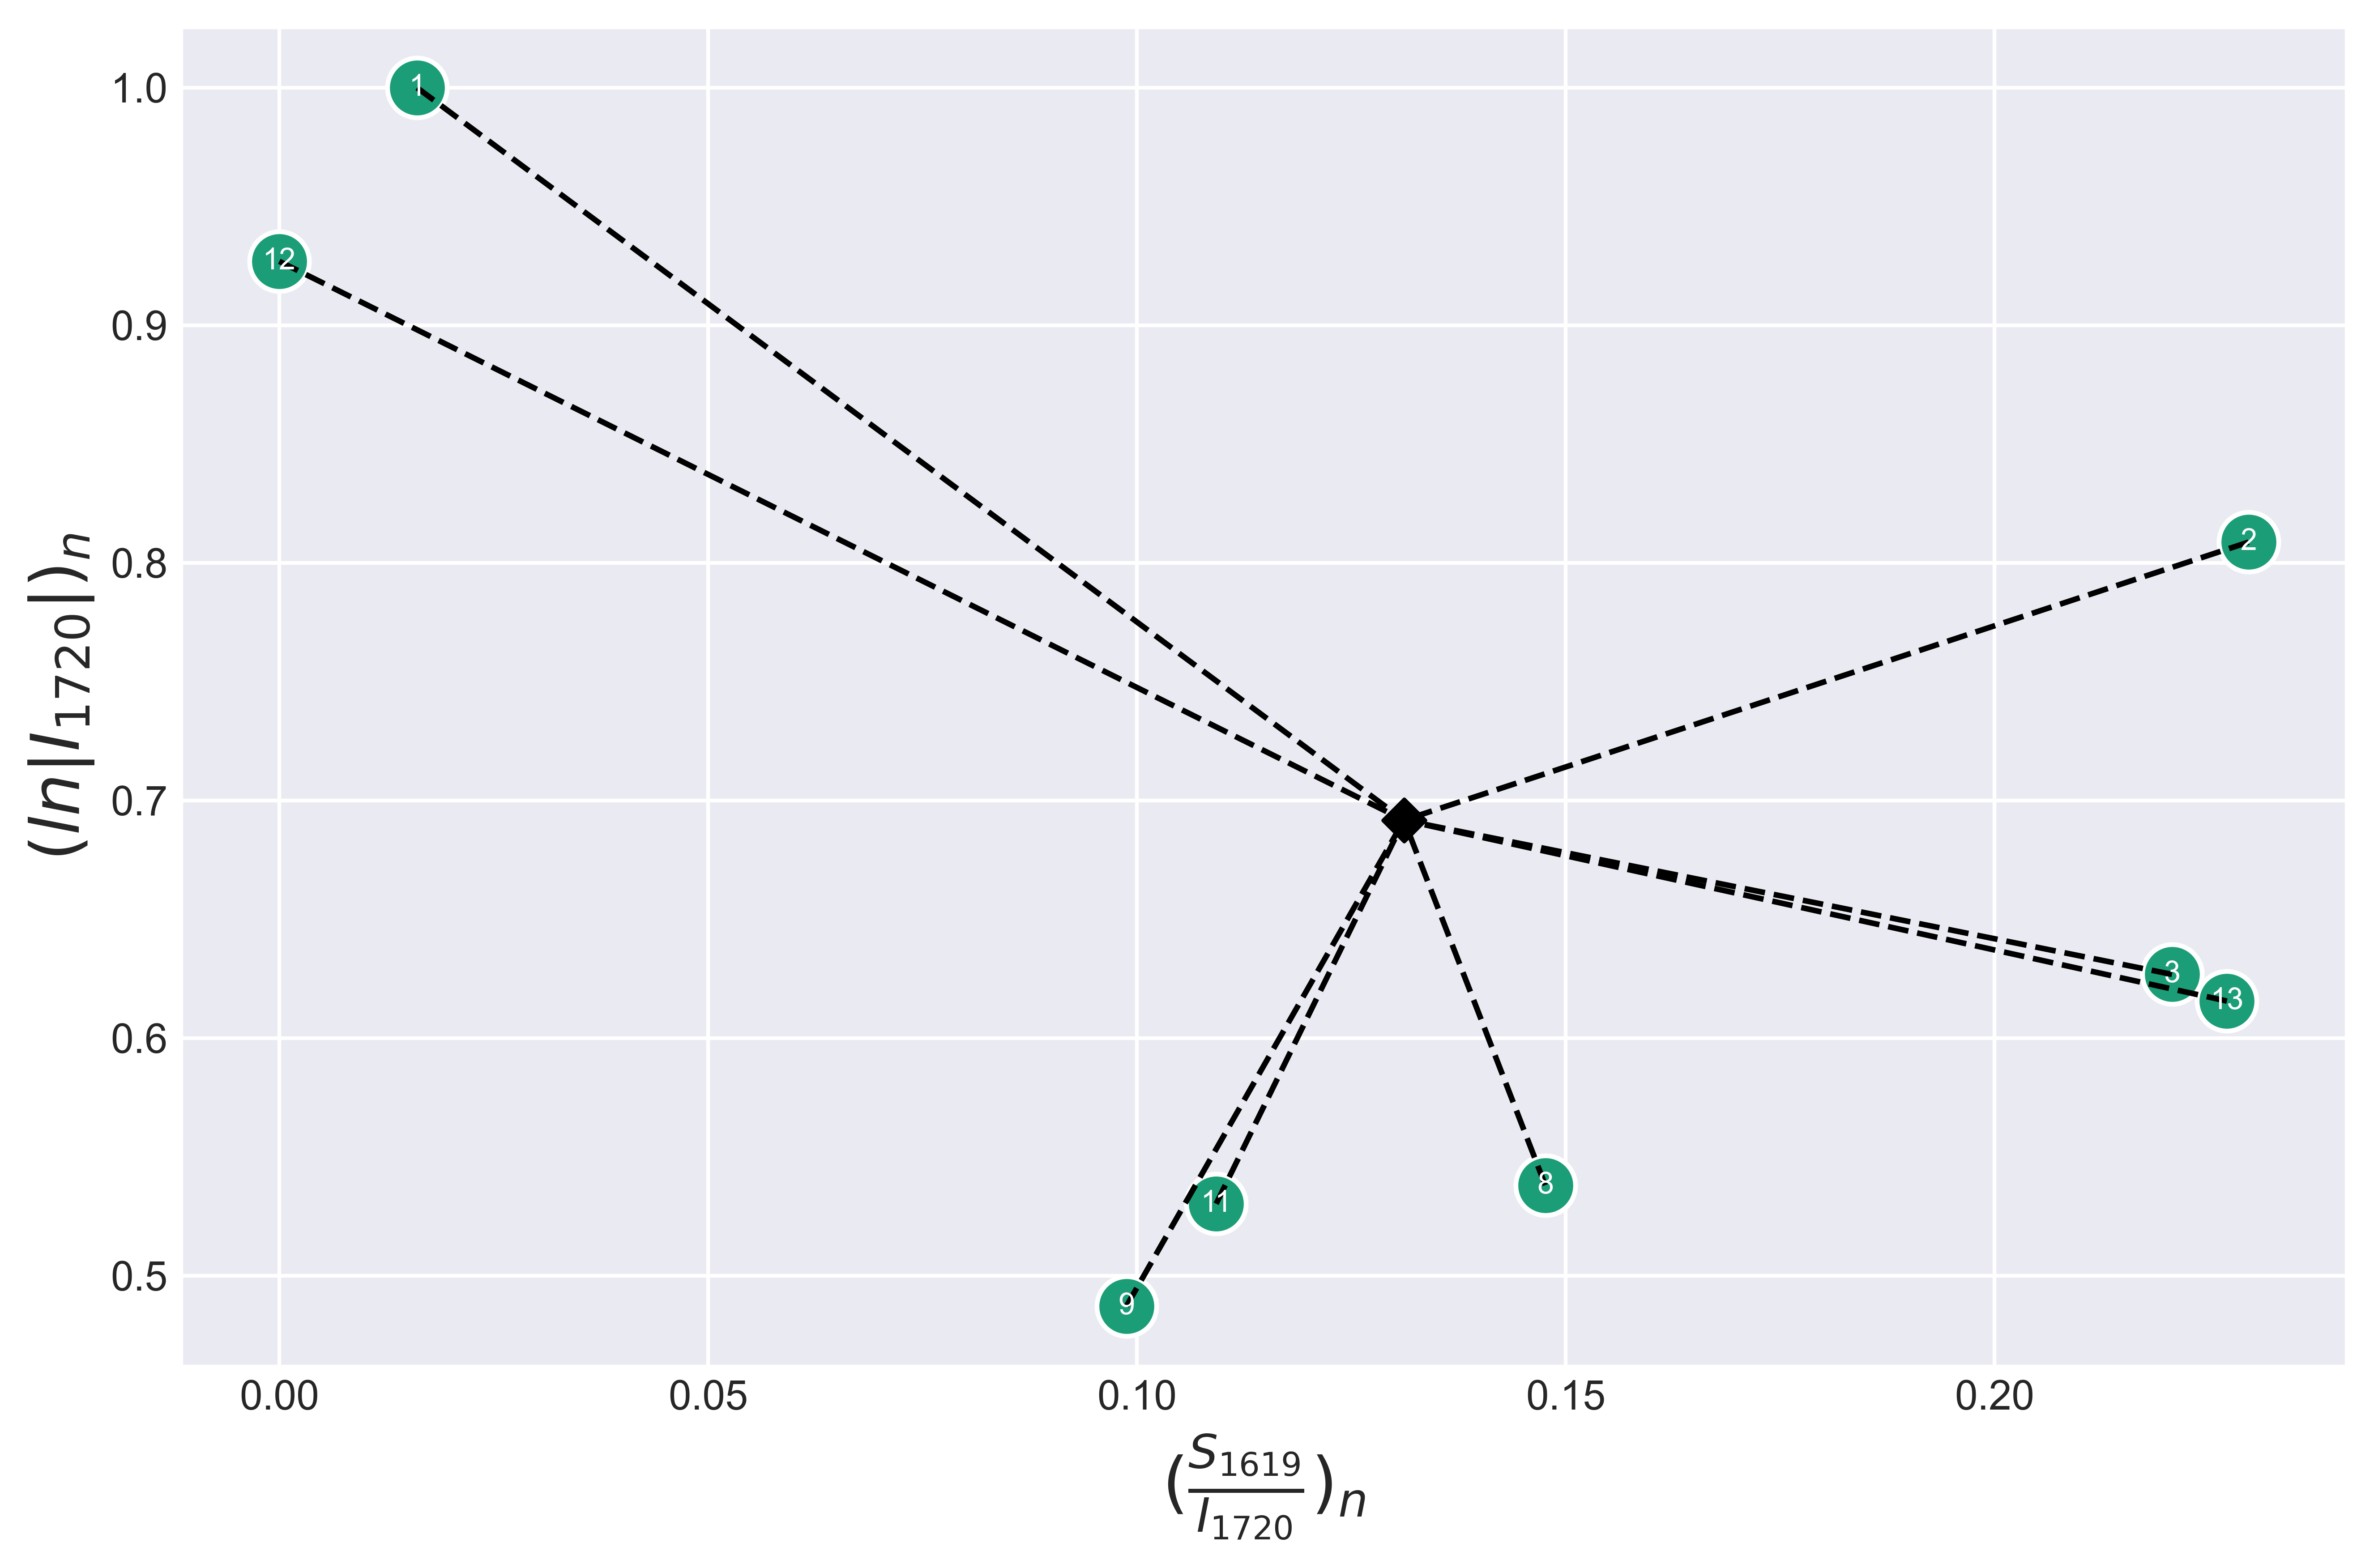

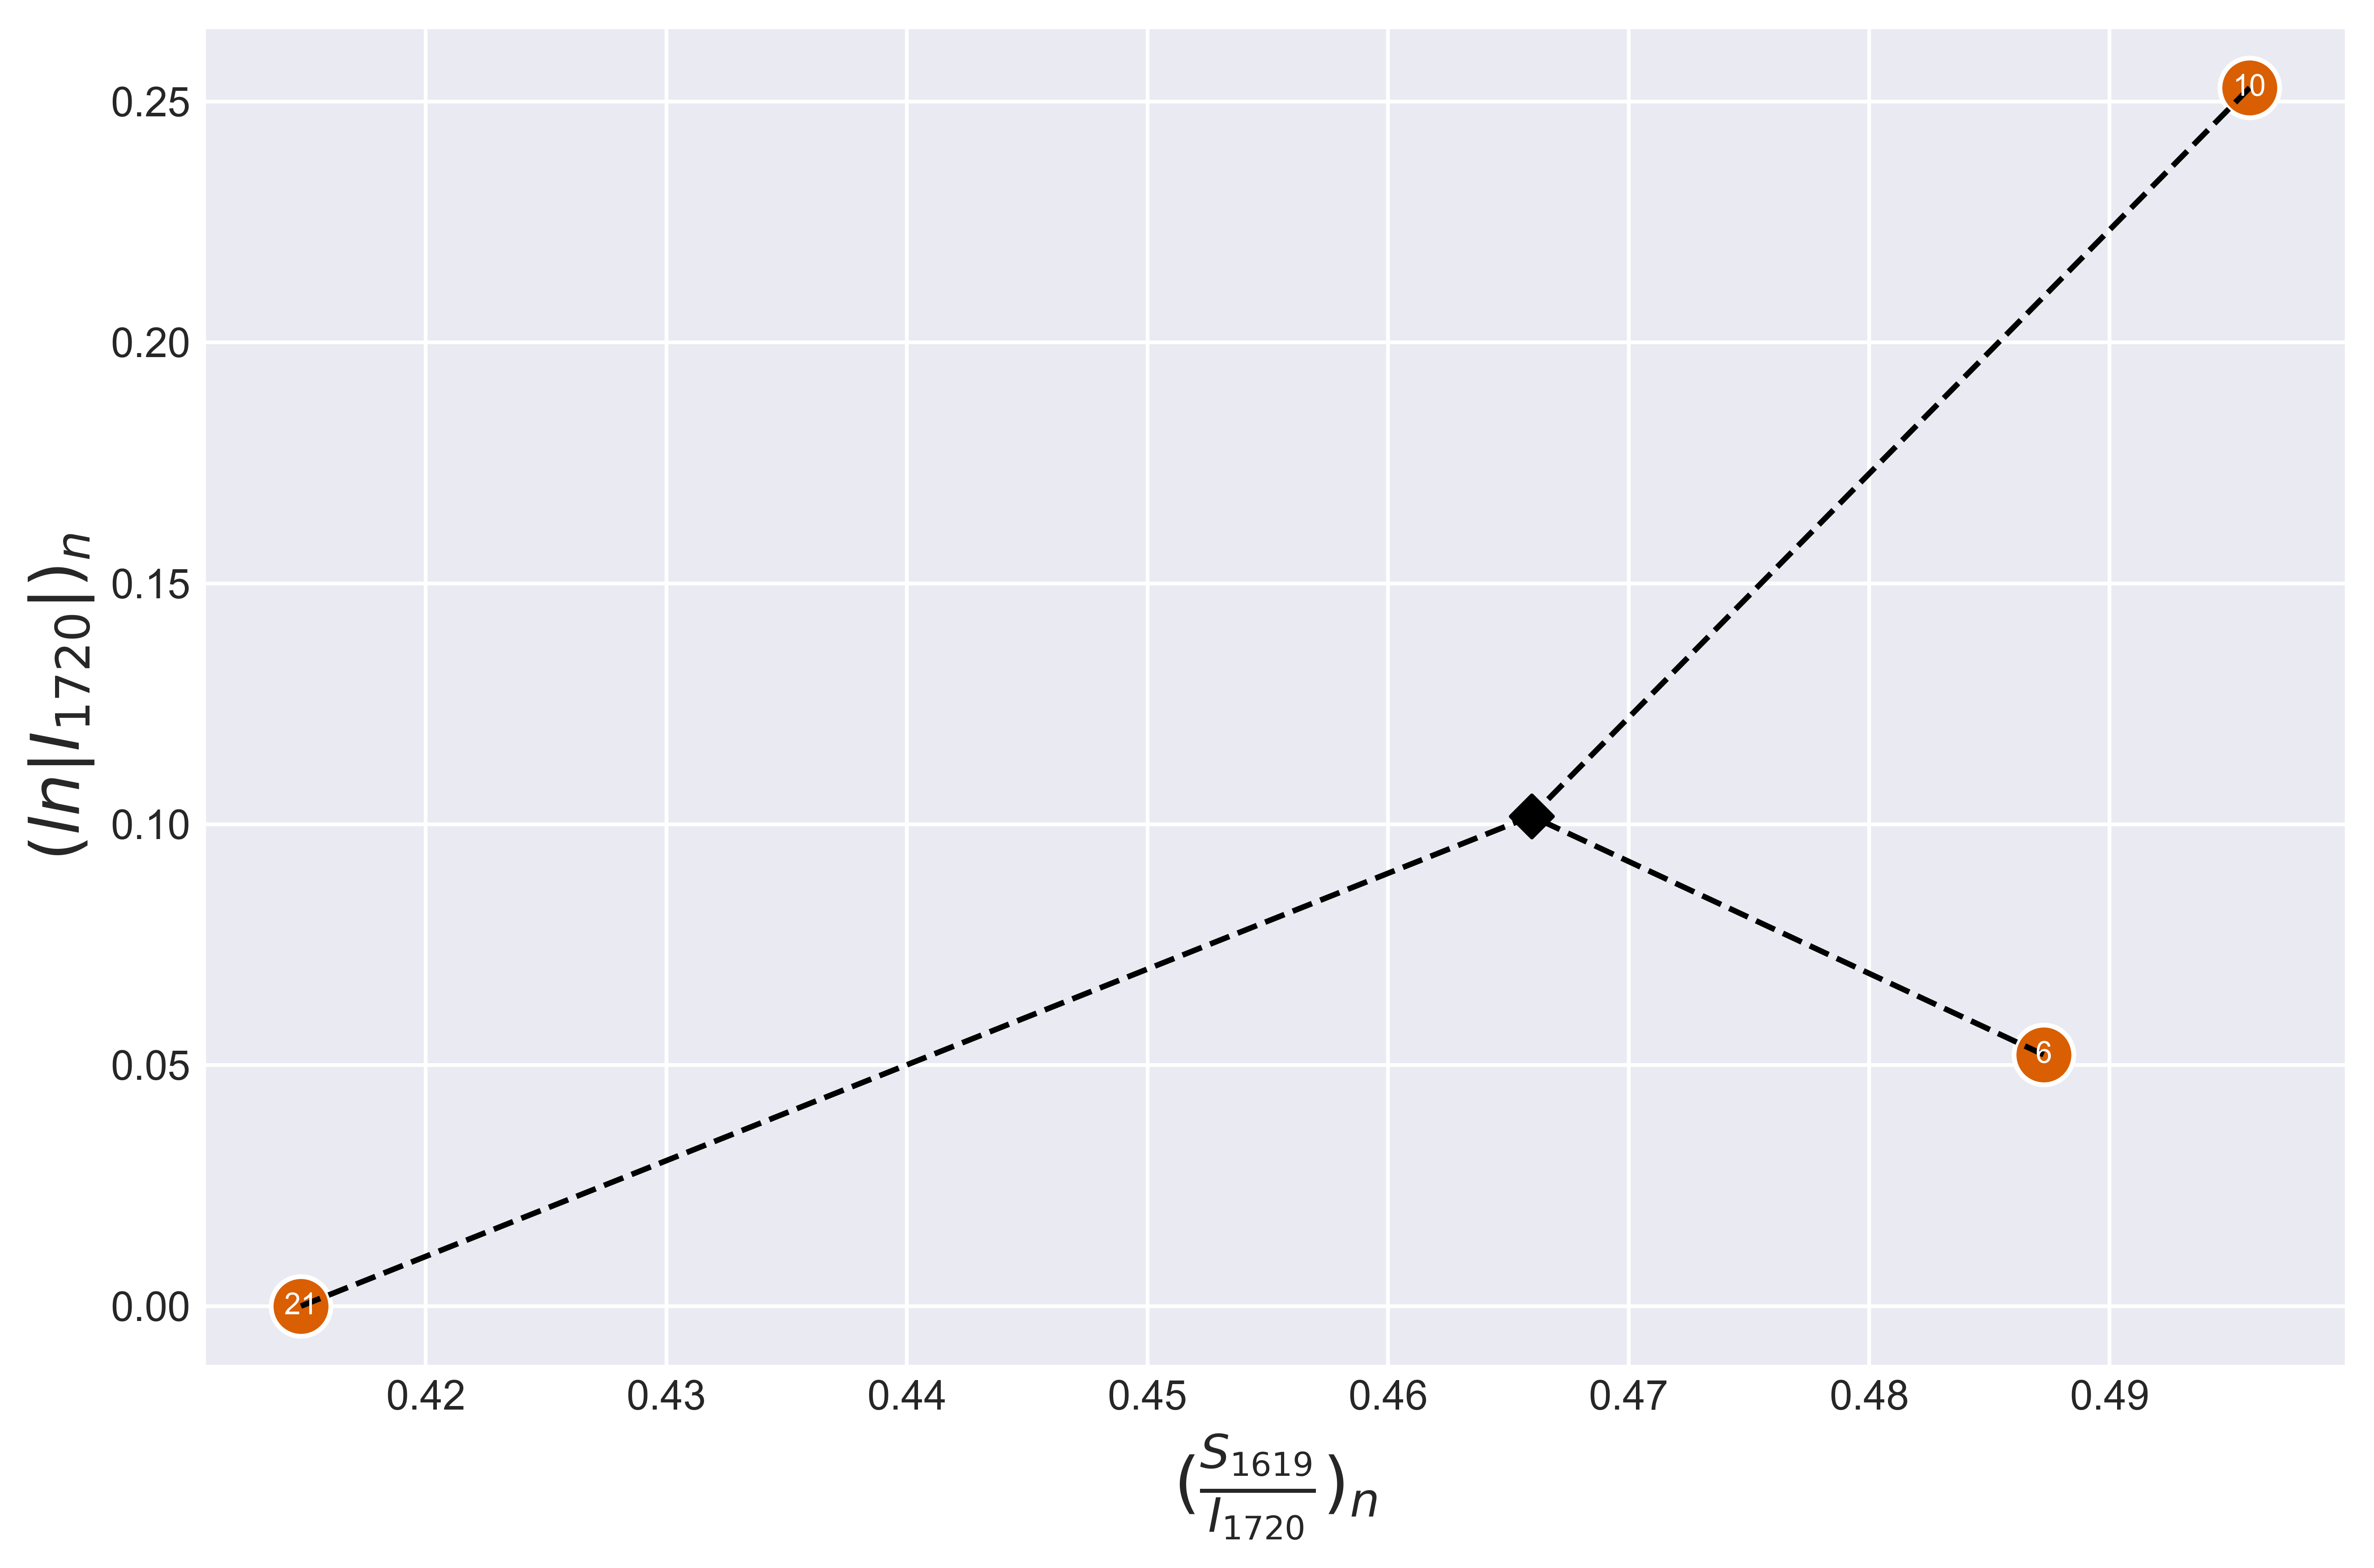

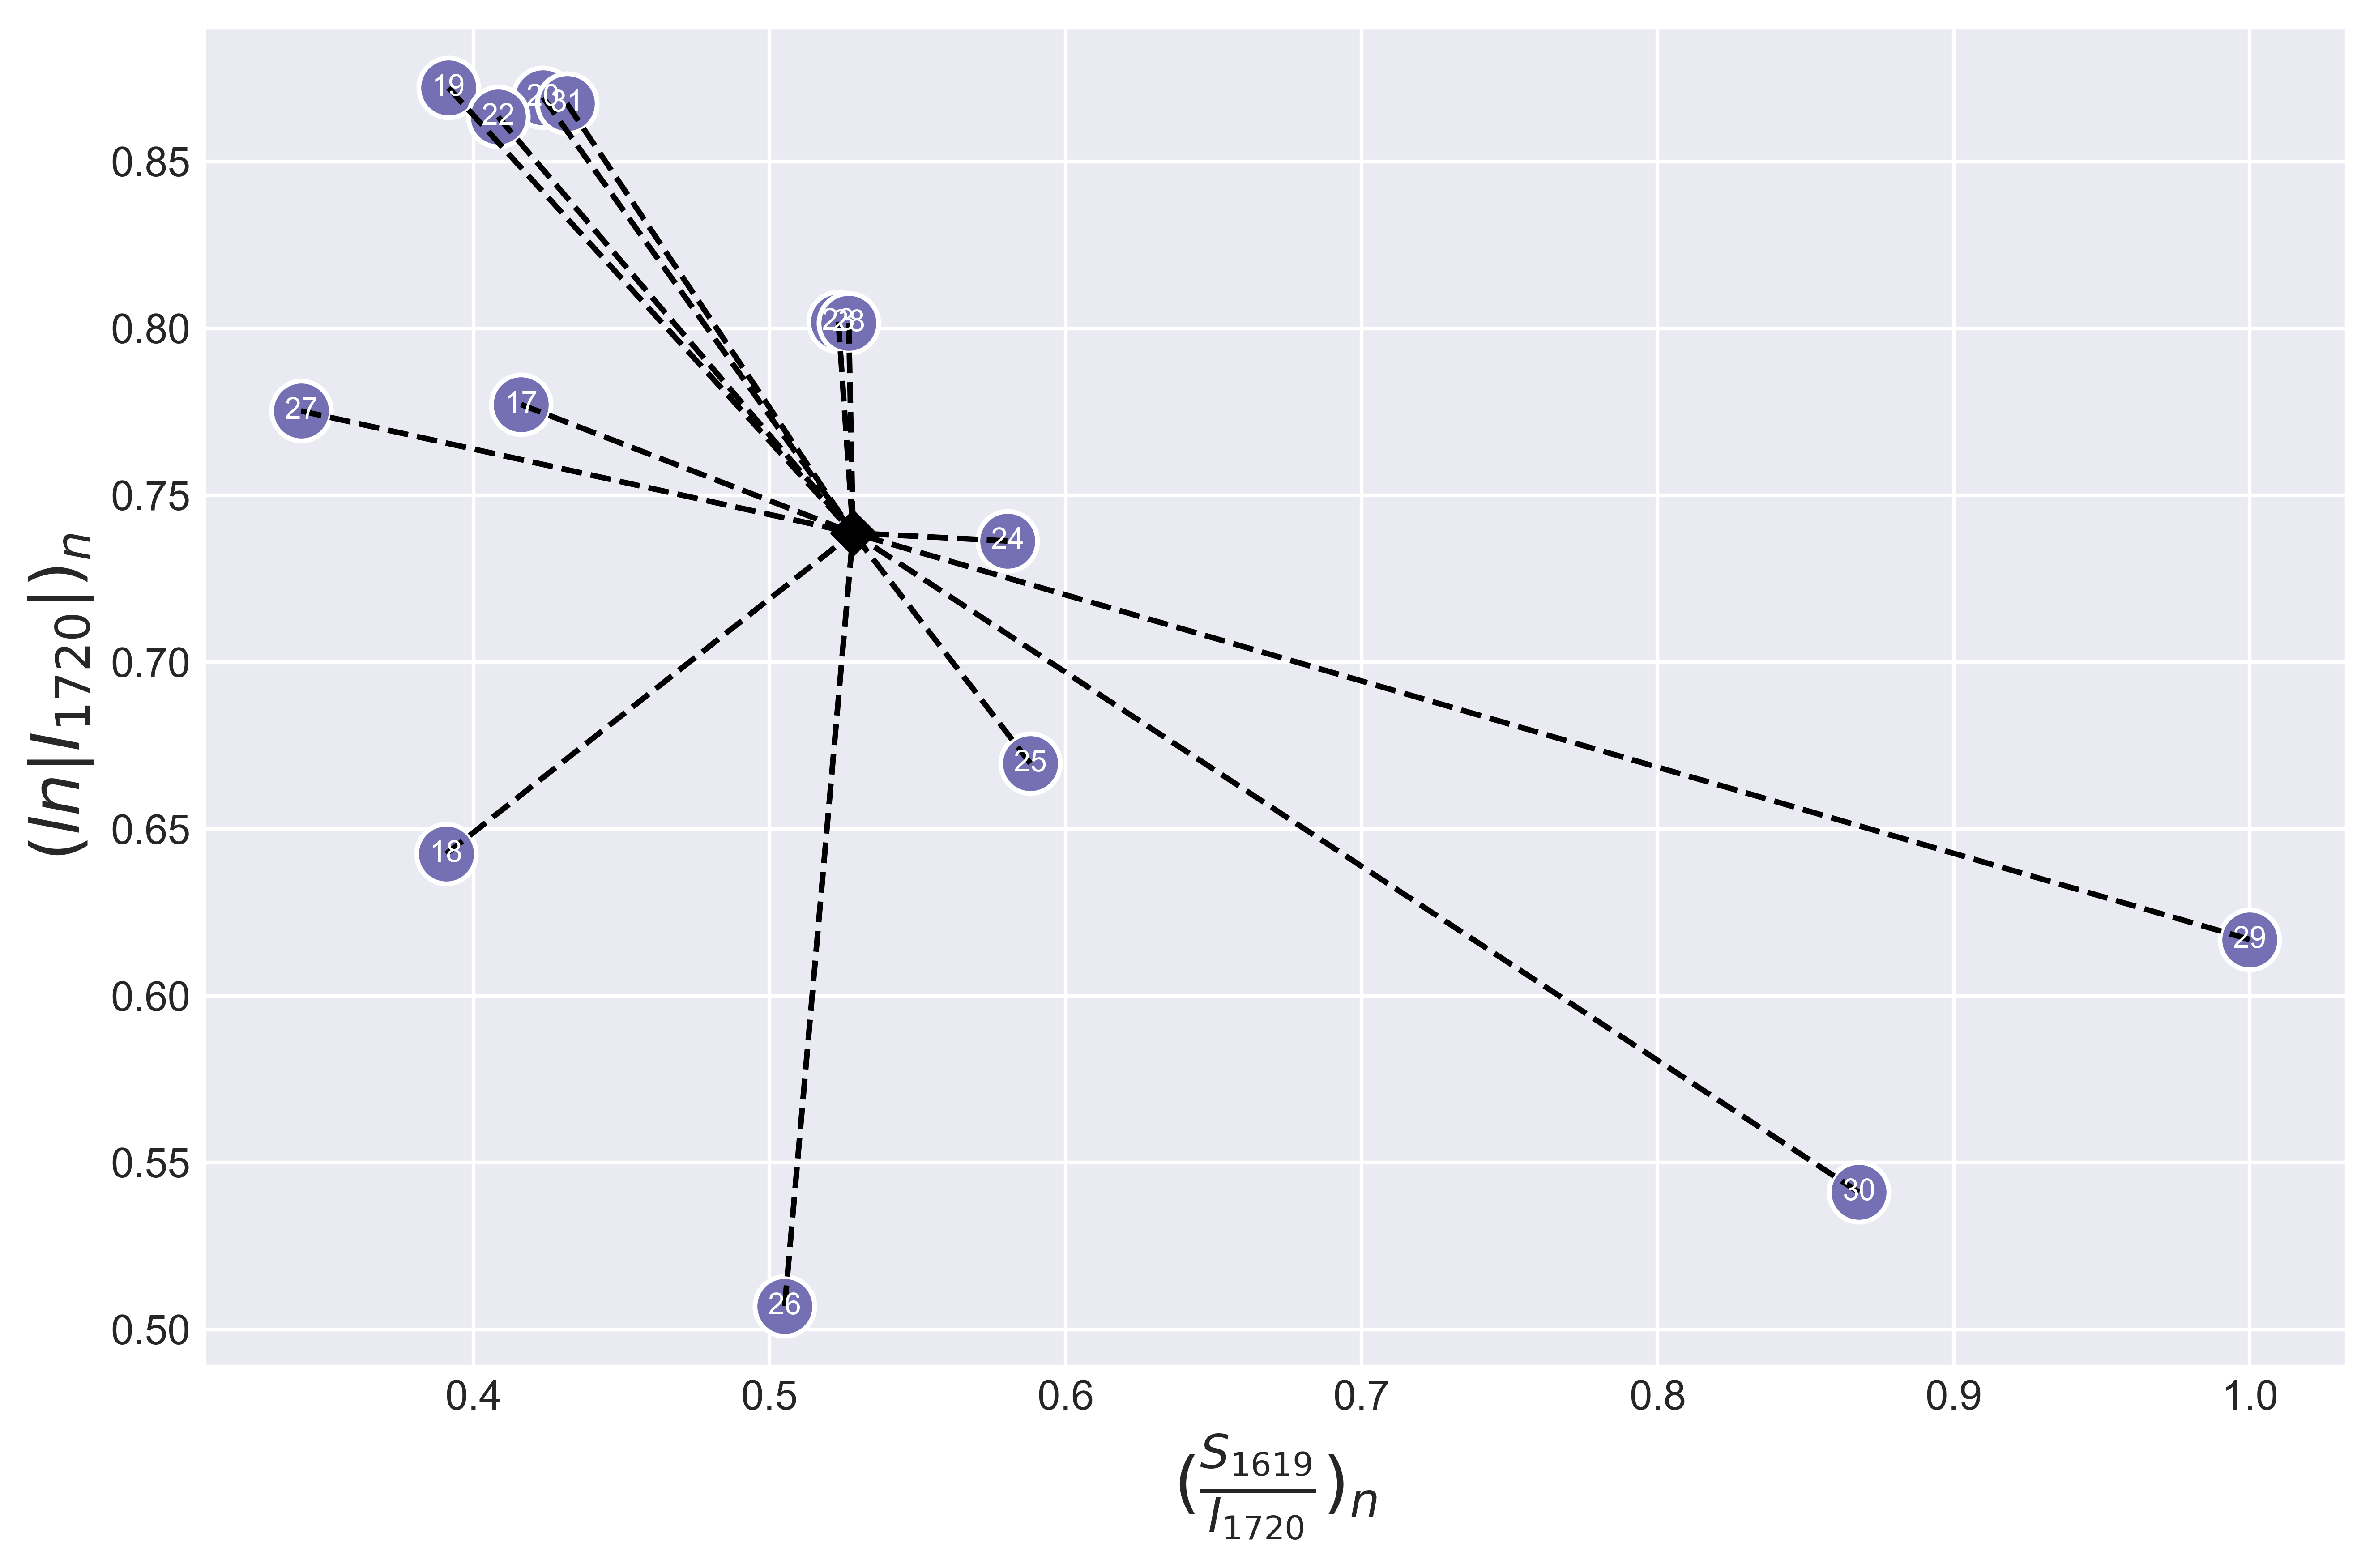

In [44]:
sample_types = samples_description['Type'].unique().tolist()
colors_lst = ['#1b9e77', '#d95f02', '#7570b3']

n = 0

for i, sample_type in enumerate(sample_types):
    feature_1, feature_2 = qm_df_vis_top['Feature_1'].tolist()[n], qm_df_vis_top['Feature_2'].tolist()[n]

    sample_type_indexes = samples_description.loc[samples_description['Type'] == sample_type].index
    
    top_features_pair_df = data.loc[:, [feature_1, feature_2]].loc[sample_type_indexes]
        
    target = samples_description['Class'].loc[sample_type_indexes]
    hue = samples_description['Type'].loc[sample_type_indexes]
    
    analyzer = ClusterAnalysis2D(target=target, hue=hue)
    
    opt_n_cluster = analyzer.optimize_n_clusters(train_data=top_features_pair_df,
                                                 metric='v_measure')
    
    analyzer.fit_transform_kmeans(train_data=top_features_pair_df,
                                  n_clusters=opt_n_cluster)
    
    analyzer.get_clustering_visualization(
        figsize=(9.0, 6.0),
        markersize=256,
        fontsize=18,
        palette=None,
        color=colors_lst[i],
        print_point_labels=True,
        path_to_save=None,
        dpi=600
    )

## Collecting images for *graphical abstract*

In [45]:
path_to_graphical_abstract = './../../results/graphical_abstract'

In [56]:
feature_pairs =[
    '[$(\\frac{S_{1619}}{I_{1720}})_{n}$; $(ln|I_{1720}|)_{n}$]',
    '[$S_{1619, n}$; $(\\frac{ΣI}{I_{1720}})_{n}$]',
    '[$(\\frac{ΣS}{I_{1720}})_{n}$; $(\\frac{S_{1619}}{I_{1720}})_{n}$]'
]

barplot_data = qm_df_vis_top.loc[qm_df_vis_top['Feature_Pair'].isin(feature_pairs)]

fontsize = 8

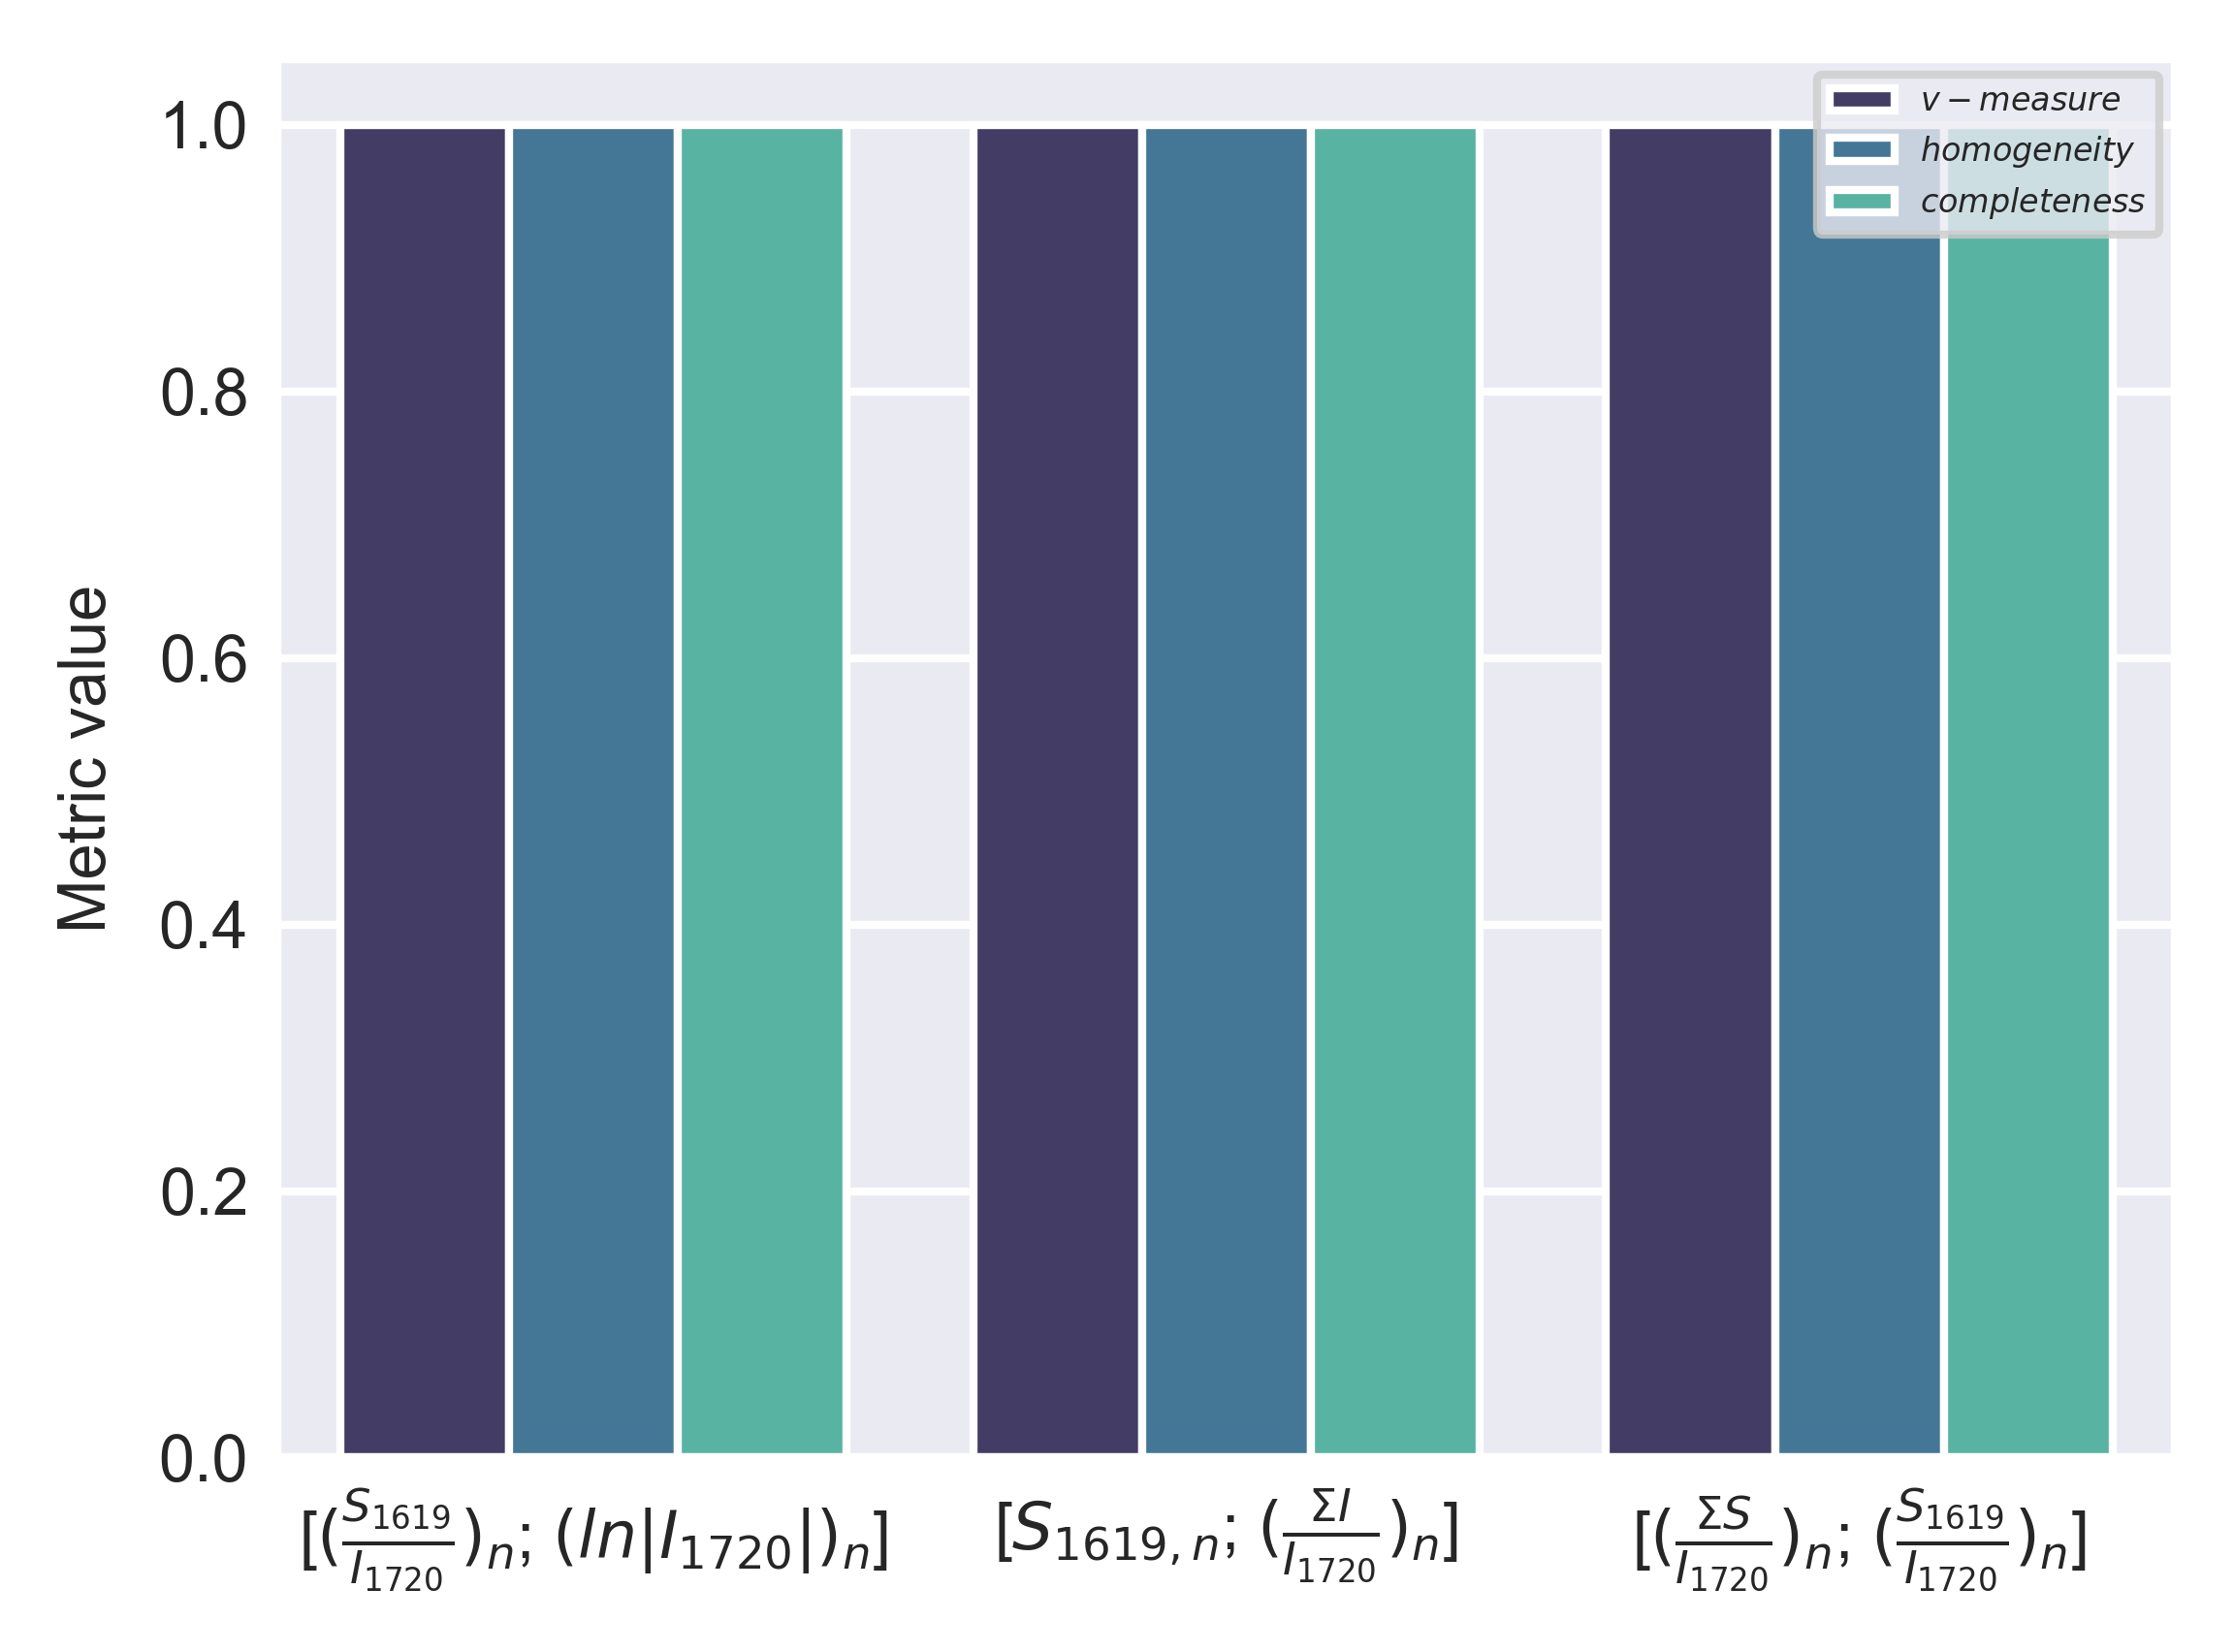

In [57]:
sns.set_theme()

fig = plt.figure(figsize=(4, 3), dpi=600, linewidth=1.0)

ax = fig.gca()

ax.grid(True)
ax.tick_params(direction='in')

bar = sns.barplot(data=barplot_data,
                  x='Feature_Pair',
                  y='Value',
                  hue='Metric',
                  palette='mako',
                  ax=ax)

ax.set_ylabel('Metric value',
              fontstyle='normal',
              fontsize=fontsize,
              rotation=90,
              labelpad=5)

ax.set_xlabel('')

bar.set_xticklabels(bar.get_xticklabels(), rotation=0, fontsize=fontsize)
bar.set_yticklabels(bar.get_yticklabels(), rotation=0, fontsize=fontsize)

ax.legend(loc='upper right', fontsize=fontsize // 2)

plt.tight_layout()

# plt.savefig(path_to_graphical_abstract + '/qm_barplot.png', dpi=600)

plt.show()

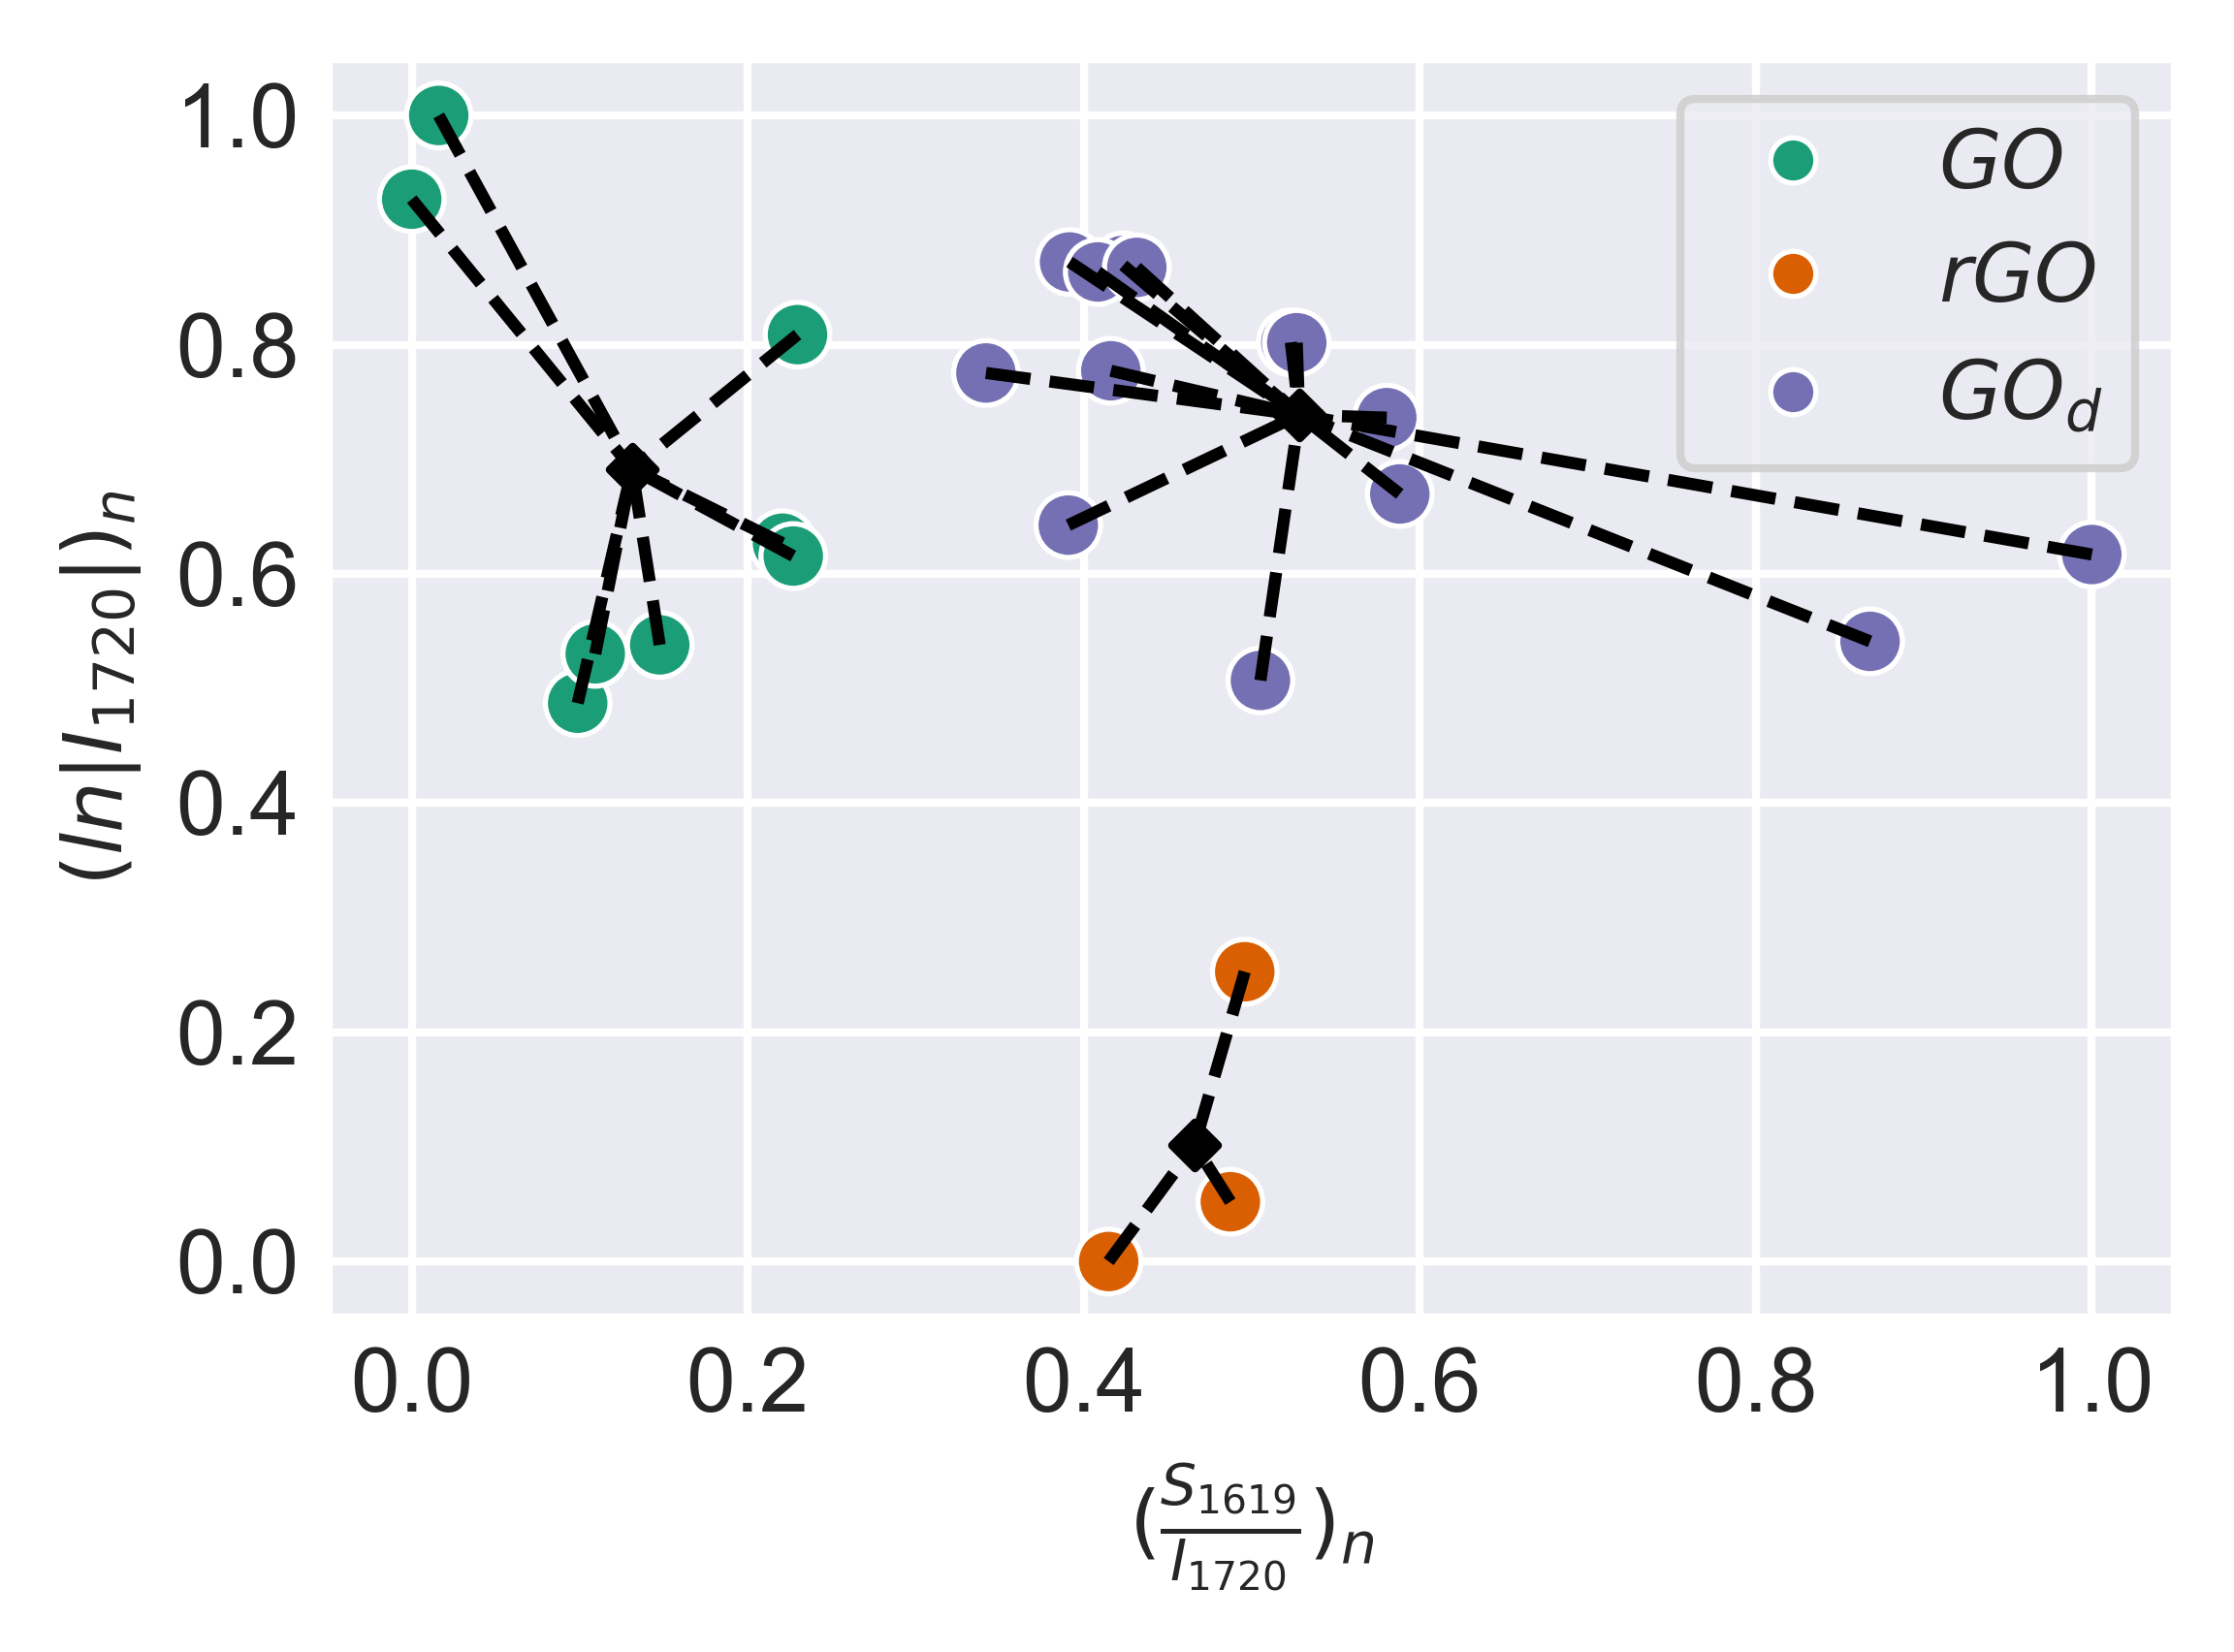

In [58]:
i = 0

feature_1, feature_2 = qm_df_vis_top['Feature_1'].tolist()[i], qm_df_vis_top['Feature_2'].tolist()[i]

top_features_pair_df = data.loc[:, [feature_1, feature_2]]

target = samples_description['Class']
hue = samples_description['Type']

analyzer = ClusterAnalysis2D(target=target, hue=hue)

opt_n_cluster = analyzer.optimize_n_clusters(train_data=top_features_pair_df,
                                             metric='v_measure')

analyzer.fit_transform_kmeans(train_data=top_features_pair_df,
                              n_clusters=opt_n_cluster)

analyzer.get_clustering_visualization(figsize=(4, 3),
                                      markersize=64,
                                      fontsize=10,
                                      # path_to_save=path_to_graphical_abstract + f'/scatterplot_top{i}.png',
                                      dpi=600)